In [2]:
# !pip install pyarrow
# !pip install optuna
# !pip install optuna-integration
# !pip install shap

In [3]:
# Imports de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns      
import missingno as msno
import statsmodels.api as sm
import matplotlib.dates as mdates

from apafib import load_dormir
from scipy import stats
from time import time
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import copy


import warnings
warnings.filterwarnings('ignore')

# Definiciones
RND = 16

sns.set(style="whitegrid", font_scale=1.05)

# Funciones auxiliares
def format_pval(p):
    if p == 0:
        return r"$0$"
    exp = int(np.floor(np.log10(p)))
    if exp >= -3:
        return f"{p:.4f}"                
    else:
        mant = p / (10.0**exp)
        return rf"${mant:.2f}\times10^{{{exp}}}$"
    
# quitar warnings:
import warnings
warnings.filterwarnings("ignore", message="findfont:.*")

init_time = time()

# Práctica de APA - Ajuste de modelos y conclusiones

## Introducción

**Autores:** Oriol Farrés y Marc Gil

En este notebook vamos a probar diferentes modelos de ML para predecir quién gana un partido de tenis y ver cuál funciona mejor. Como es un problema de clasificación, hemos seleccionado estos modelos:

**Modelos más simples (lineales/cuadráticos):**
1. Regresión logística
2. K-NN
3. SVM lineal

**Modelos más complejos (no lineales):**
1. Random Forest
2. XGBoost
3. Neural Networks
4. Ensamble

---

### Criterio de evaluación

Para que los resultados sean fiables usamos validación cruzada. Como tenemos datos temporales, usaremos **TimeSeriesSplit** en vez de K-Fold normal.

**Importante:** El test set solo lo usamos al final para ver cómo generalizan los modelos y asegurarnos de que no hay overfitting. El criterio principal para elegir el mejor modelo es el score de cross-validation. El test solo se usa como criterio de desempate si dos modelos tienen el mismo CV score.

---

# Índice

## Parte 1 - Preparación de datos

**Fase A: Cargar datos**
1. Preámbulo

**Fase B: Preprocesado**
0. Definiciones útiles
1. Split X e y
2. Definir columnas y pipelines
3. Aplicar pipelines

**Fase C: Reducción de dimensionalidad**
1. PCA
2. t-SNE
3. Comentarios

## Parte 2 - Ajuste de modelos

0. Definiciones

**Fase A: Modelos simples**
1. Regresión logística
2. K-NN
3. SVM lineal

**Fase B: Modelos complejos**
1. Random Forest
2. XGBoost
3. Neural Networks
4. Ensamble

## Parte 3 - Comparación

## Parte 4 - Interpretabilidad

1. Importancia de features
2. Comparación lineales vs no lineales
3. SHAP para modelo lineal
4. SHAP para modelo no lineal
5. Análisis de ejemplos específicos
6. Conclusiones

## Parte 5 - Conclusiones


<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Parte 1 - Preparación

# Fase A - Cargar datos

## A.1 - Preámbulo

Cargamos los datasets limpios (train y test) que ya generamos en el notebook anterior.


In [4]:
tennis_train = pd.read_parquet("data/clean/atp_matches_train.parquet")
tennis_test = pd.read_parquet("data/clean/atp_matches_test.parquet")

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase B - Preprocesado

Vamos a usar pipelines de sklearn para que todo el preprocesado sea consistente y no haya leaks.

## B.0 - Definiciones útiles

Primero definimos qué variables son numéricas, categóricas, etc. para simplificar el código después.


In [5]:
# Definimos target
target = 'Winner'

features = tennis_train.columns.drop(target).tolist()
numerical_features = tennis_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = tennis_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Eliminar el target de las númericas (está codificada ya como 0/1)
numerical_features.remove(target)

print("--- Clasificación de Variables ---")
print(f"Target: {target}")
print(f"Numéricas ({len(numerical_features)}): {numerical_features}")
print(f"Categóricas ({len(categorical_features)}): {categorical_features}")

--- Clasificación de Variables ---
Target: Winner
Numéricas (42): ['draw_size', 'best_of', 'tourney_points', 'diff_elo_blend', 'diff_days_since', 'diff_injury', 'diff_seed', 'diff_ht', 'diff_age', 'diff_rank', 'diff_rank_points', 'diff_h2h', 'diff_is_seeded', 'diff_is_first_match', 'diff_1st_won_pct_last_10', 'diff_tb_rate_last_1', 'diff_bp_save_pct_last_5', 'diff_is_rookie', 'diff_df_pct_last_1', 'diff_df_pct_last_10', 'diff_ace_pct_last_1', 'diff_bp_save_pct_lifetime', 'diff_df_pct_last_5', 'diff_tb_rate_last_5', 'diff_tb_won_pct_last_10', 'diff_1st_won_pct_last_1', 'diff_bp_save_pct_last_10', 'diff_ace_pct_last_10', 'diff_tb_won_pct_last_5', 'diff_win_rate_last_10', 'diff_1st_won_pct_last_5', 'diff_ace_pct_last_5', 'diff_win_rate_last_5', 'diff_tb_won_pct_last_1', 'diff_1st_won_pct_lifetime', 'diff_win_rate_last_1', 'diff_win_rate_lifetime', 'diff_tb_rate_last_10', 'diff_tb_rate_lifetime', 'diff_bp_save_pct_last_1', 'diff_elo', 'diff_elo_surface']
Categóricas (6): ['surface', 'tourn

---

## B.1 - Split X e y

Separamos las features (X) del target (y) tanto para train como test.


In [6]:

X_train = tennis_train.drop(columns=[target])
y_train = tennis_train[target]

X_test = tennis_test.drop(columns=[target])
y_test = tennis_test[target]

---

## B.2 - Pipelines

Definimos los transformadores para cada tipo de variable (escalado para numéricas, encoding para categóricas).


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn import set_config

set_config(transform_output="pandas")

# Variables Numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Variables Categóricas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

---

## B.3-Aplicar Pipelines

In [8]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features),
    #('ord', ord_pipeline, ordinal_features)
], verbose_feature_names_out=False)

Aunque no vamos a usar X_processed, ya que los modelos usarán cada uno la pipeline directamente, definimos X_processed para el PCA y t-SNE que si lo necesitan (y para verificar que no peta nada).

In [9]:
print("\n--- Verificación del Preprocesador (Primeras 3 filas transformadas) ---")
X_train_processed = preprocessor.fit_transform(X_train)
display(X_train_processed.head(3))

# Aprovechamos para definir la constante
FEATURE_NAMES = X_train_processed.columns.tolist()


--- Verificación del Preprocesador (Primeras 3 filas transformadas) ---


draw_size   best_of  tourney_points  diff_elo_blend  diff_days_since  \
0   1.722584  1.982285        1.850274        0.245639         0.011717   
1  -0.665468 -0.504468       -0.800901        0.396306        -1.892586   
2   1.722584 -0.504468        0.335317       -0.466828         0.002100   

   diff_injury  diff_seed   diff_ht  diff_age  diff_rank  ...  p1_entry_SE  \
0     0.095430  -0.011298  0.496184 -0.842070  -0.225087  ...          0.0   
1    -3.547269  -0.011298  0.000099  0.686485  -0.085928  ...          0.0   
2     0.095430  -0.011298 -2.281892 -0.373081   0.147257  ...          0.0   

   p1_entry_WC  p1_hand_R  p2_entry_DA  p2_entry_LL  p2_entry_PR  p2_entry_Q  \
0          0.0        1.0          1.0          0.0          0.0         0.0   
1          0.0        1.0          0.0          1.0          0.0         0.0   
2          0.0        1.0          1.0          0.0          0.0         0.0   

   p2_entry_SE  p2_entry_WC  p2_hand_R  
0          0.0          0.0        1.0  
1          0.0          0.0        0.0  
2          0.0          0.0        1.0  

[3 rows x 63 columns]

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase C - Reducción de dimensionalidad

Aquí vamos a probar PCA y t-SNE para ver si las clases se separan mejor en menos dimensiones.

1. PCA
2. t-SNE
3. Comparación y conclusiones

## C.1 - PCA

Primero probamos PCA para ver cuánta varianza capturamos con cada componente.

In [10]:
from sklearn.decomposition import PCA

myPCA = PCA().fit(X_train_processed)
print(myPCA.explained_variance_ratio_.cumsum())

[0.19830929 0.31751353 0.3833527  0.44125368 0.49483443 0.54097136
 0.58212885 0.61897052 0.64920035 0.67603287 0.70125509 0.72462014
 0.74710719 0.76735552 0.78566008 0.80178647 0.81696994 0.8311307
 0.84485957 0.85734285 0.86944879 0.88004354 0.89043473 0.90042038
 0.90993897 0.91814791 0.92623418 0.93364315 0.94053263 0.94720748
 0.95223166 0.95724426 0.9619293  0.96628742 0.97008721 0.97341097
 0.97671658 0.97994139 0.9827379  0.98539886 0.98791088 0.98975224
 0.99140958 0.99301775 0.99459573 0.9960573  0.99746407 0.99823106
 0.99871019 0.99914338 0.99944193 0.99958824 0.99973038 0.9998637
 0.99991548 0.99996217 0.99999276 0.99999816 0.99999938 1.
 1.         1.         1.        ]


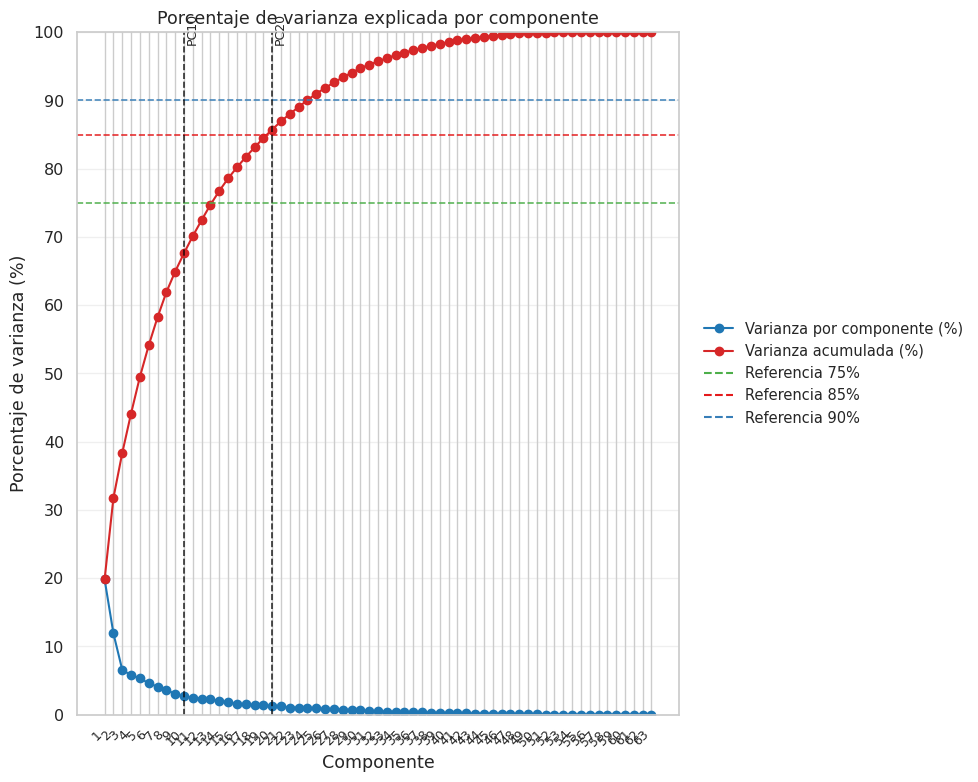

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))

evr = myPCA.explained_variance_ratio_
cum_evr = evr.cumsum()
evr_pct = evr * 100
cum_pct = cum_evr * 100
m = len(evr_pct)
x = np.arange(1, m + 1)

line1, = ax.plot(x, evr_pct, marker='o', color='#1f77b4', label='Varianza por componente (%)', linewidth=1.5)
line2, = ax.plot(x, cum_pct, marker='o', color='#d62728', label='Varianza acumulada (%)', linewidth=1.5)

ref_levels = [75, 85, 90]
ref_colors = ['#4daf4a', '#e41a1c', '#377eb8']
for lvl, col in zip(ref_levels, ref_colors):
    ax.axhline(lvl, color=col, linestyle='--', linewidth=1.2, alpha=0.9)

# líneas verticales en PC10 y PC20 (si existen)
if m >= 10:
    ax.axvline(10, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
    ax.text(10 + 0.2, ax.get_ylim()[1]*0.98, 'PC10', rotation=90, va='top', ha='left', fontsize=9)
if m >= 20:
    ax.axvline(20, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
    ax.text(20 + 0.2, ax.get_ylim()[1]*0.98, 'PC20', rotation=90, va='top', ha='left', fontsize=9)

ax.set_xlabel('Componente')
ax.set_ylabel('Porcentaje de varianza (%)')
ax.set_title('Porcentaje de varianza explicada por componente')

ax.set_xticks(x)
if m > 10:
    ax.set_xticklabels(x, rotation=45, ha='right', fontsize=9)
else:
    ax.set_xticklabels(x)

ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 101, 10))
ax.grid(axis='y', alpha=0.3)

from matplotlib.lines import Line2D
data_handles, data_labels = ax.get_legend_handles_labels()
ref_handles = [Line2D([0], [0], color=c, lw=1.5, linestyle='--') for c in ref_colors]
ref_labels = [f'Referencia {int(l)}%' for l in ref_levels]
ax.legend(data_handles + ref_handles, data_labels + ref_labels,
          loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small', frameon=False)

plt.tight_layout()
plt.show()

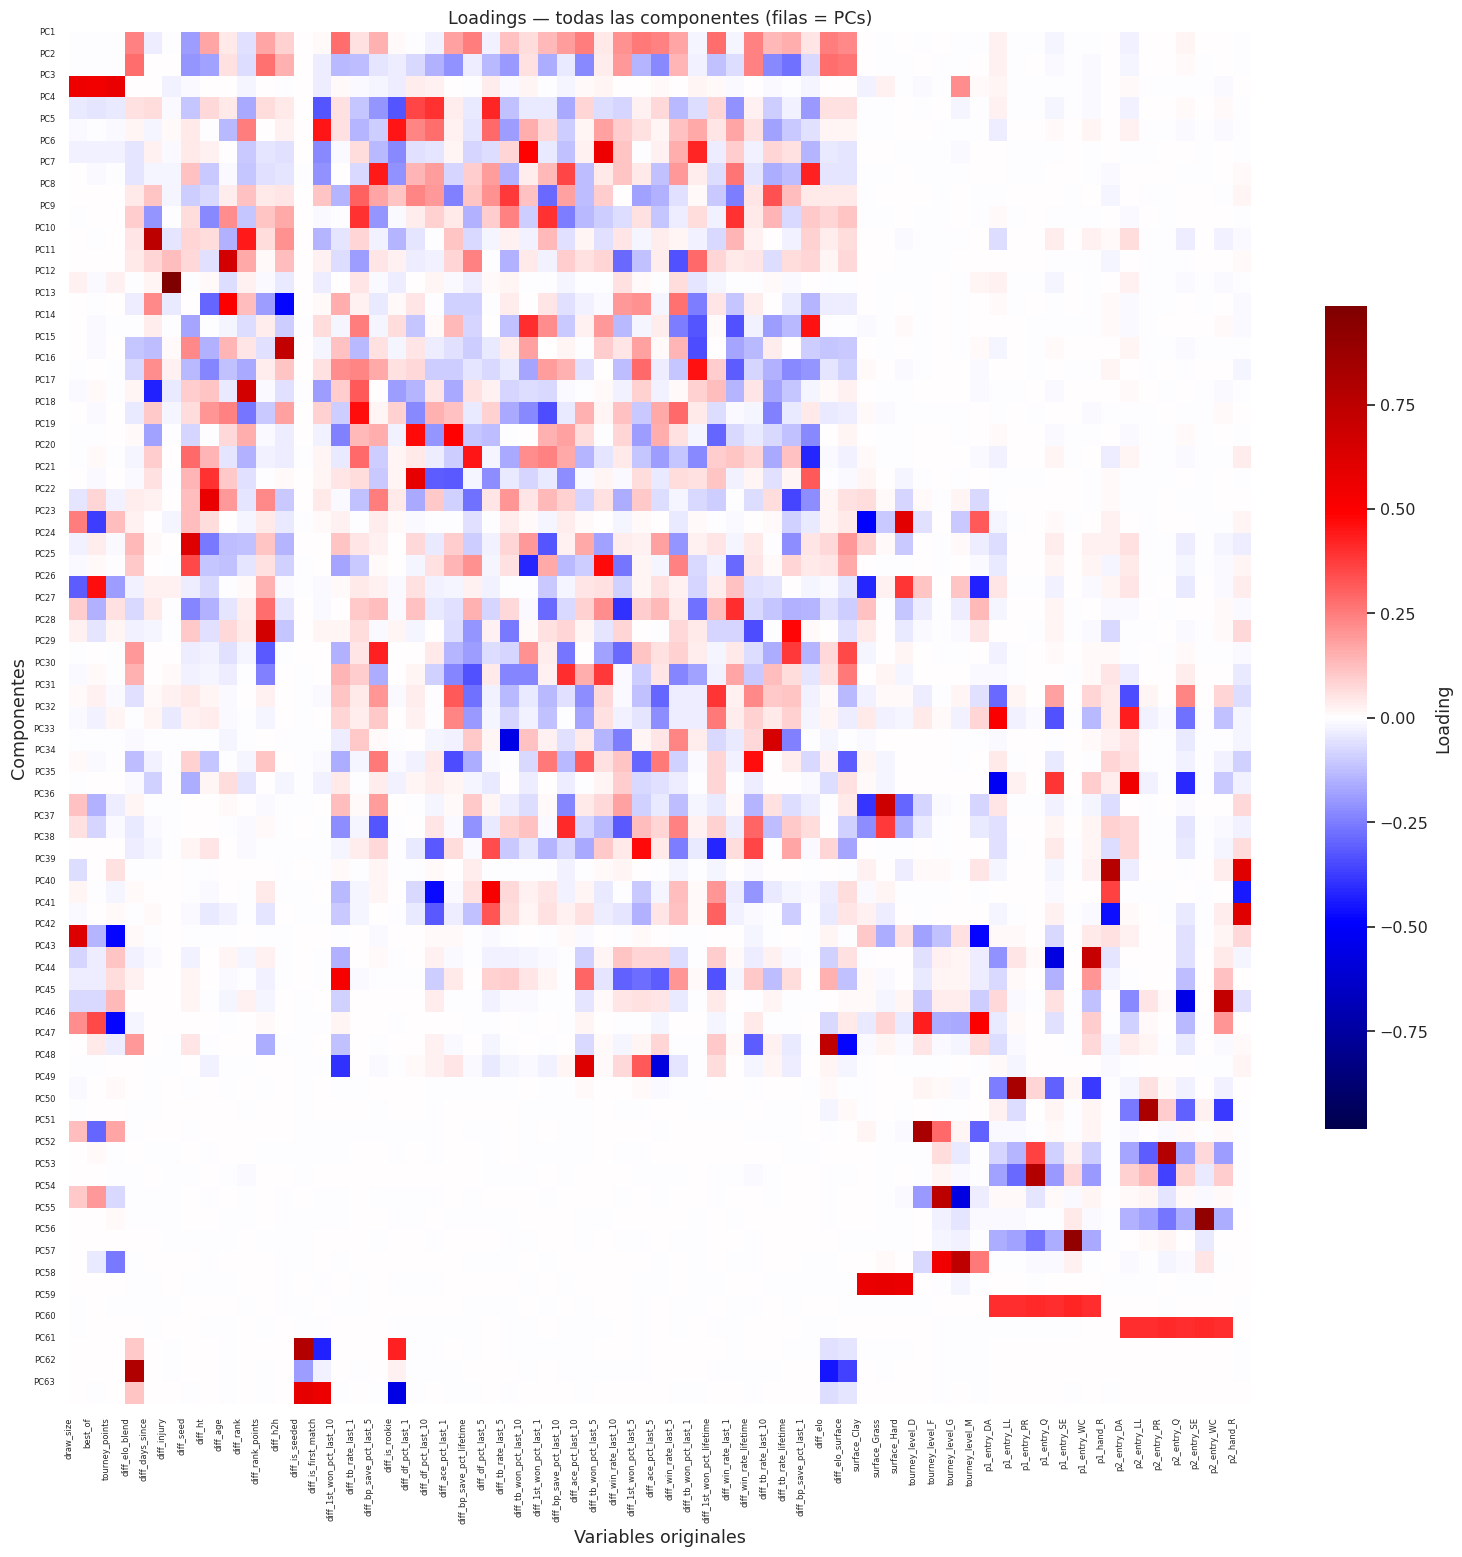

In [12]:
components = myPCA.components_ 
pc_labels = [f'PC{i+1}' for i in range(components.shape[0])]
comp_df = pd.DataFrame(components, index=pc_labels, columns=FEATURE_NAMES)

n_rows, n_cols = comp_df.shape
fig_w = max(12, n_cols * 0.25)
fig_h = max(6, n_rows * 0.25)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

v = np.max(np.abs(comp_df.values))
sns.heatmap(
    comp_df,cmap='seismic',center=0,annot=False,fmt=".3f",
    vmin=-v,vmax=v,cbar_kws={'label': 'Loading', 'shrink': 0.6},ax=ax
)

ax.set_title('Loadings — todas las componentes (filas = PCs)')
ax.set_xlabel('Variables originales')
ax.set_ylabel('Componentes')

ax.set_xticks(np.arange(n_cols))
if n_cols > 30:
    ax.set_xticklabels(comp_df.columns, rotation=90, fontsize=6)
else:
    ax.set_xticklabels(comp_df.columns, rotation=45, ha='right', fontsize=8)

ax.set_yticks(np.arange(n_rows))
ax.set_yticklabels(comp_df.index, rotation=0, fontsize=max(6, min(9, 200//n_rows)))

plt.tight_layout()
plt.show()

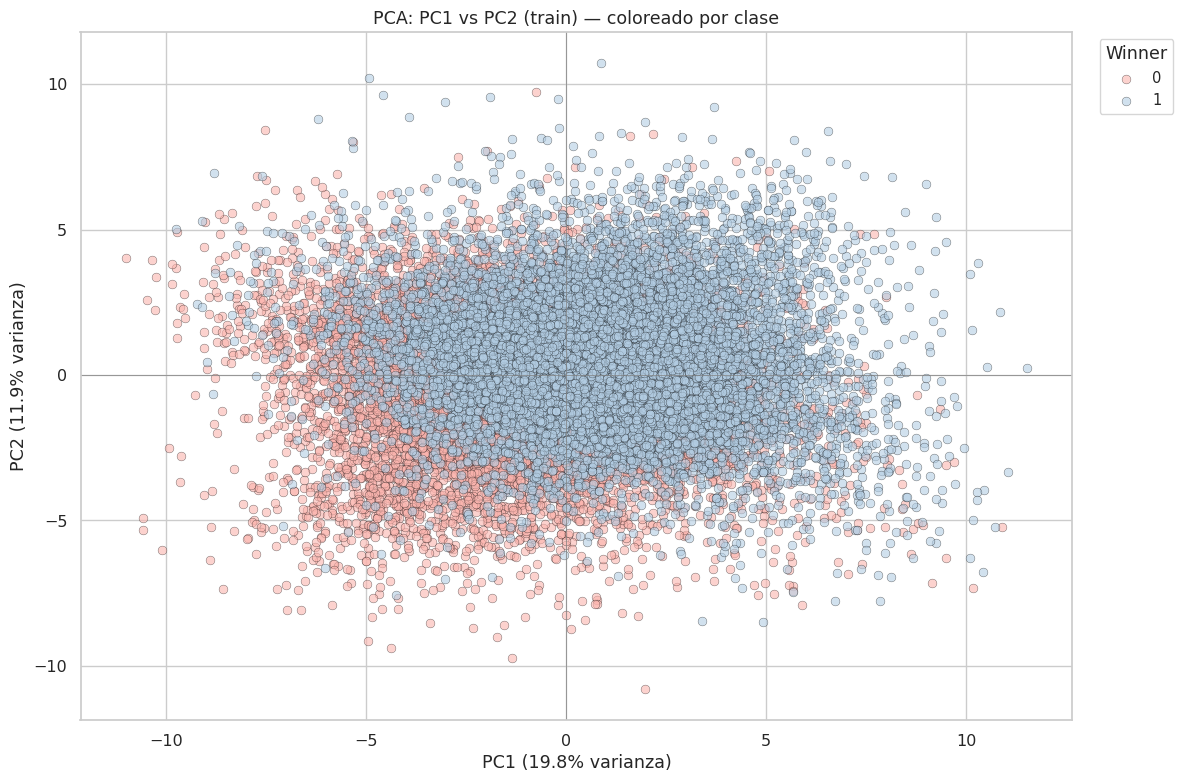

In [13]:
pca_result = myPCA.transform(X_train_processed)
pca_result = np.asarray(pca_result)

expl_var = myPCA.explained_variance_ratio_ * 100

unique_classes = np.unique(y_train)
palette = sns.color_palette("Pastel1", n_colors=len(unique_classes))
plt.figure(figsize=(12, 8))
ax = plt.gca()

for i, cls in enumerate(unique_classes):
    mask = (y_train.values == cls)
    ax.scatter(
        pca_result[mask, 0],
        pca_result[mask, 1],
        label=cls,
        s=40,
        alpha=0.6,
        edgecolor='black',
        linewidth=0.3,
        color=palette[i % len(palette)]
    )

ax.set_xlabel(f'PC1 ({expl_var[0]:.1f}% varianza)')
ax.set_ylabel(f'PC2 ({expl_var[1]:.1f}% varianza)')
ax.axhline(0, color='grey', linewidth=0.5)
ax.axvline(0, color='grey', linewidth=0.5)
ax.set_title('PCA: PC1 vs PC2 (train) — coloreado por clase')

ax.legend(title=target, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

--- 
## C.2 - t-SNE

Ahora probamos t-SNE, que es mejor para visualizar clusters no lineales.

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=RND,
    perplexity=30.0,
    learning_rate='auto', 
    n_jobs=-1,            
    max_iter=1000,
    verbose=1
)

print("Iniciando ajuste de t-SNE (sobre datos estandarizados)...")

X_train_tsne = tsne.fit_transform(X_train_processed)

Iniciando ajuste de t-SNE (sobre datos estandarizados)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25155 samples in 0.003s...
[t-SNE] Computed neighbors for 25155 samples in 0.613s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25155
[t-SNE] Computed conditional probabilities for sample 2000 / 25155
[t-SNE] Computed conditional probabilities for sample 3000 / 25155
[t-SNE] Computed conditional probabilities for sample 4000 / 25155
[t-SNE] Computed conditional probabilities for sample 5000 / 25155
[t-SNE] Computed conditional probabilities for sample 6000 / 25155
[t-SNE] Computed conditional probabilities for sample 7000 / 25155
[t-SNE] Computed conditional probabilities for sample 8000 / 25155
[t-SNE] Computed conditional probabilities for sample 9000 / 25155
[t-SNE] Computed conditional probabilities for sample 10000 / 25155
[t-SNE] Computed conditional probabilities for sample 11000 / 25155
[t-SNE] Computed conditional probabilities for sample 12000 

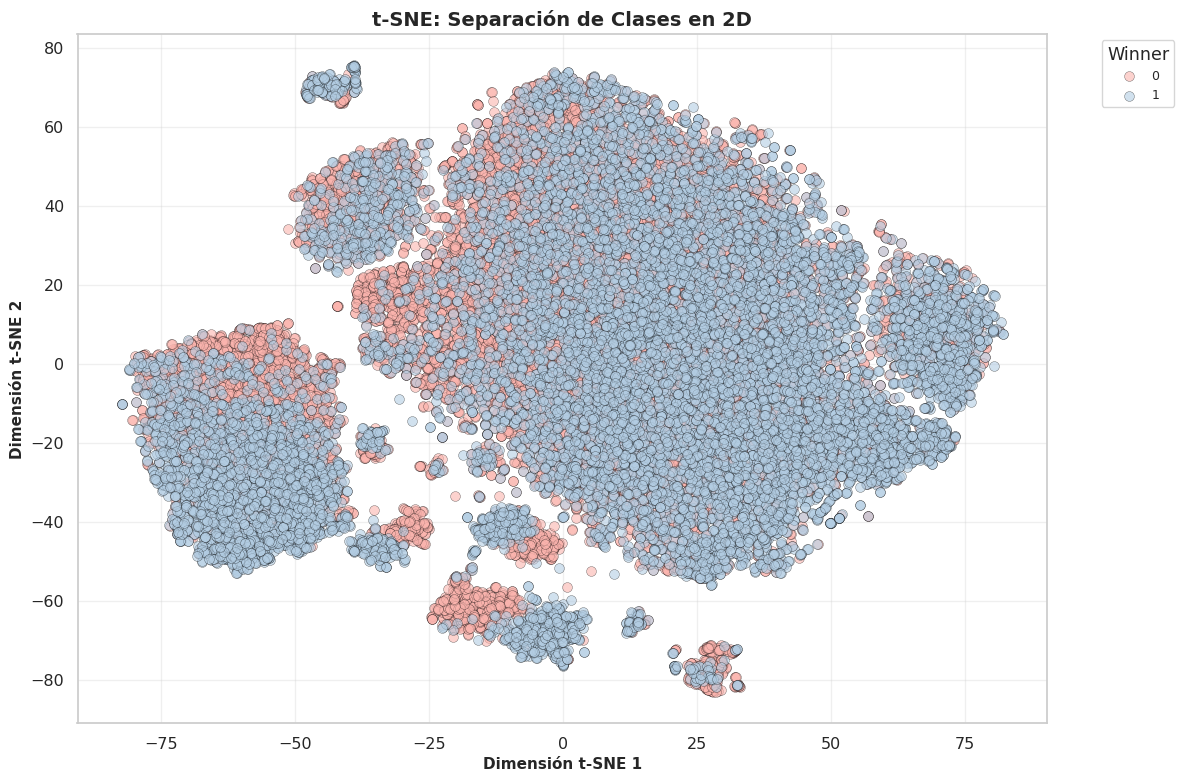

In [15]:
# Visualización en 2D con t-SNE
X_train_tsne = np.asarray(X_train_tsne)
unique_classes = np.unique(y_train)
palette = sns.color_palette("Pastel1", n_colors=len(unique_classes))

plt.figure(figsize=(12, 8))
for i, cls in enumerate(unique_classes):
    mask = (y_train.values == cls)       
    plt.scatter(
        X_train_tsne[mask, 0],
        X_train_tsne[mask, 1],
        label=cls,
        alpha=0.6,
        s=50,
        color=palette[i % len(palette)],
        edgecolors='black',
        linewidth=0.3
    )

plt.xlabel('Dimensión t-SNE 1', fontsize=11, fontweight='bold')
plt.ylabel('Dimensión t-SNE 2', fontsize=11, fontweight='bold')
plt.title('t-SNE: Separación de Clases en 2D', fontsize=14, fontweight='bold')
plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## C.3 - Comparación PCA vs t-SNE

Vamos a comparar los dos métodos lado a lado para ver cuál separa mejor las clases.

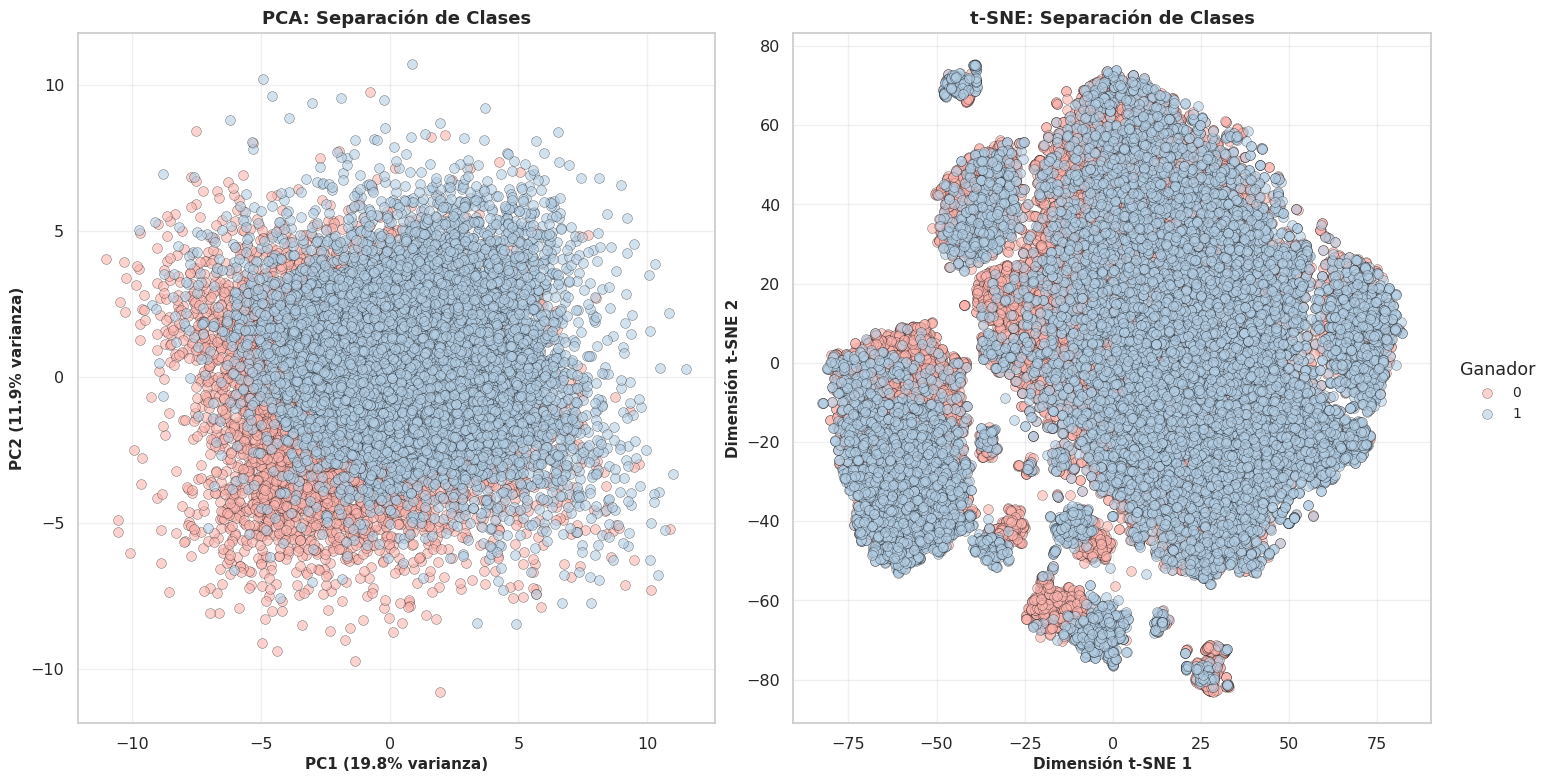

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

X_pca = next((globals().get(n) for n in ('X_train_pca','pca_result') if globals().get(n) is not None), None)
if X_pca is None:
    X_pca = myPCA.transform(X_train_processed)

evr = myPCA.explained_variance_ratio_
palette = sns.color_palette("Pastel1", n_colors=len(np.unique(y_train)))

# --- Gráfico 1: PCA ---
for i, obesity_class in enumerate(np.unique(y_train)):
    mask = (y_train == obesity_class).values if isinstance(y_train, pd.Series) else (y_train == obesity_class)
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    label=obesity_class, alpha=0.6, s=50,
                    color=palette[i % len(palette)], edgecolors='black', linewidth=0.3)

axes[0].set_xlabel(f'PC1 ({evr[0]*100:.1f}% varianza)', fontsize=11, fontweight='bold')
axes[0].set_ylabel(f'PC2 ({evr[1]*100:.1f}% varianza)', fontsize=11, fontweight='bold')
axes[0].set_title('PCA: Separación de Clases', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# --- Gráfico 2: t-SNE ---
for i, obesity_class in enumerate(np.unique(y_train)):
    mask = (y_train == obesity_class).values if isinstance(y_train, pd.Series) else (y_train == obesity_class)
    axes[1].scatter(X_train_tsne[mask, 0], X_train_tsne[mask, 1],
                    label=obesity_class, alpha=0.6, s=50,
                    color=palette[i % len(palette)], edgecolors='black', linewidth=0.3)

axes[1].set_xlabel('Dimensión t-SNE 1', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Dimensión t-SNE 2', fontsize=11, fontweight='bold')
axes[1].set_title('t-SNE: Separación de Clases', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
plt.subplots_adjust(right=0.9) 

fig.legend(handles, labels, title='Ganador',
           loc='center left',           
           bbox_to_anchor=(0.91, 0.5),  
           fontsize=10,
           frameon=False)               

plt.show()

### Interpretación

Mirando los gráficos, se ve que ni PCA ni t-SNE separan bien las clases. Los puntos de ambos ganadores (P1 y P2) están muy mezclados en las dos visualizaciones.

**PCA:** Solo captura el ~15-20% de la varianza en las primeras 2 componentes, lo que indica que la información está muy distribuida. Esto tiene sentido porque en tenis hay muchos factores que influyen en el resultado.

**t-SNE:** Aunque es mejor para capturar relaciones no lineales, tampoco consigue separar las clases. Esto sugiere que el problema es intrínsecamente difícil - predecir el ganador no es tan simple como encontrar clusters claros en los datos.

**Conclusión:** No usaremos reducción de dimensionalidad para los modelos. Vamos a usar todas las features porque la separación en espacios reducidos no es buena.

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Parte 2 - Ajuste de modelos

## 0. Definiciones

Antes de empezar, vamos a aclarar qué métricas usaremos. La matriz de confusión funciona así:

* **TP (True Positives):** Predijimos que gana P1 y ganó P1 
* **TN (True Negatives):** Predijimos que gana P2 y ganó P2 
* **FP (False Positives):** Predijimos P1 pero ganó P2 
* **FN (False Negatives):** Predijimos P2 pero ganó P1 

Hemos mirado diferentes métricas:

1. **Accuracy:** % total de aciertos
2. **Precision:** De los que predigo como ganadores, cuántos aciertan
3. **Recall:** De los ganadores reales, cuántos pillo
4. **F1-score:** Media armónica de precision y recall

**Decisión:** Como no hay desbalance de clases y nos da igual equivocarnos en un sentido u otro, vamos a maximizar **Accuracy**.

---

Para no liarnos y que todos los modelos se entrenen igual, vamos a usar una función común para todo.

In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.base import clone
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, CategoricalDistribution, IntDistribution


# Configuración global
RND = 16                
MAX_ITER = 1000        
SCORING_SYSTEM = 'accuracy' 
N_CV = 5            

# Colores para cada modelo (para outputs bonitos)
COLOR_MAP_ANSI = {
    'Blues': '\033[1;34m',    
    'GnBu': '\033[1;36m',   
    'Purples': '\033[1;35m',  
    'Greens': '\033[1;32m',   
    'Oranges': '\033[1;33m',  
    'Reds': '\033[1;31m',    
    'Greys': '\033[1;37m',
    'Golds': '\033[1;93m',
    'YlOrBr': '\033[1;33m'
}
RESET_CODE = '\033[0m'

MODEL_TO_CMAP = {
    'LogisticRegression': 'Blues',
    'KNeighborsClassifier': 'GnBu',
    'SVC': 'Purples', 
    'LinearSVC': 'Purples',
    'RandomForestClassifier': 'Greens',
    'XGBClassifier': 'Oranges',
    'MLPClassifier': 'Reds',         
    'VotingClassifier': 'Greys',      
    'StackingClassifier': 'YlOrBr'
}

# Función para entrenar cualquier modelo con CV temporal
def ejecutar_modelo(modelo, params, X_train, y_train, preprocessor=preprocessor, 
                    cv=5, scoring='accuracy', tipo_busqueda='grid', n_iter=20):
    
    # TimeSeriesSplit para respetar el orden temporal
    tscv = TimeSeriesSplit(n_splits=cv)
    
    # Creamos el pipeline
    steps = []
    if preprocessor:
        steps.append(('preprocessor', preprocessor))
    steps.append(('clf', modelo))
    pipeline = Pipeline(steps)
    
    # Ajustamos los nombres de parámetros para el pipeline
    pipeline_params = {f'clf__{k}': v for k, v in params.items()}
    
    model_name = modelo.__class__.__name__
    cmap = MODEL_TO_CMAP.get(model_name, 'Blues')
    ansi_color = COLOR_MAP_ANSI.get(cmap, '\033[1;34m')

    print(f"\n{ansi_color}--- Iniciando entrenamiento de {model_name} ---{RESET_CODE}")
    print(f"Modo: {tipo_busqueda.upper()} search | CV: TimeSeriesSplit ({cv} splits)")

    # Seleccionar tipo de búsqueda
    if tipo_busqueda == 'grid':
        search = GridSearchCV(
            pipeline, pipeline_params, cv=tscv, scoring=scoring, n_jobs=-1, verbose=1
        )
    elif tipo_busqueda == 'random':
        search = RandomizedSearchCV(
            pipeline, pipeline_params, n_iter=n_iter, cv=tscv, scoring=scoring, 
            n_jobs=1, verbose=1, random_state=RND
        )
    elif tipo_busqueda == 'optuna':
        search = OptunaSearchCV(
            pipeline, 
            pipeline_params, 
            cv=tscv, 
            scoring=scoring, 
            n_trials=n_iter,
            random_state=RND,
            n_jobs=-1,
            verbose=1
        )
    else:
        raise ValueError("tipo_busqueda debe ser 'grid', 'random' u 'optuna'")

    # Entrenar
    optuna.logging.set_verbosity(optuna.logging.WARNING) 
    search.fit(X_train, y_train)
    
    # Mejores parámetros encontrados
    print(f"\nMejores Parámetros ({model_name}): {search.best_params_}")
    print(f"{ansi_color}>>> Best Time-Series CV {scoring.upper()}: {search.best_score_:.4f}{RESET_CODE}")
    
    # Generamos predicciones fold por fold para evaluar correctamente
    print("Generando predicciones validación cruzada temporal...")
    best_pipeline = search.best_estimator_
    actual_y = []
    predicted_y = []
    
    for train_index, test_index in tscv.split(X_train):
        fold_pipeline = clone(best_pipeline)
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        fold_pipeline.fit(X_train_fold, y_train_fold)
        fold_preds = fold_pipeline.predict(X_test_fold)
        actual_y.extend(y_test_fold)
        predicted_y.extend(fold_preds)

    y_train_valid = np.array(actual_y)
    y_pred_cv = np.array(predicted_y)

    # Reporte de clasificación y matriz de confusión
    print(f"\nResultados ({len(y_train_valid)} partidos evaluados):")
    report_dict = classification_report(y_train_valid, y_pred_cv, output_dict=True)
    style = pd.DataFrame(report_dict).transpose().style.background_gradient(
        cmap=cmap, subset=['precision', 'recall', 'f1-score'], vmin=0, vmax=1
    ).format("{:.3f}")
    display(style)
    
    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(y_train_valid, y_pred_cv, cmap=cmap, colorbar=False, ax=ax, values_format='d')
    ax.set_title(f"Confusion Matrix ({model_name})", pad=15)
    ax.grid(False)
    plt.show()
    
    return search


<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase A: Modelos líneales/cuadráticos

## A.1 - Regresión logística


--- Iniciando entrenamiento de LogisticRegression ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

Mejores Parámetros (LogisticRegression): {'clf__C': 0.06642038115806435, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'clf__class_weight': 'balanced'}
>>> Best Time-Series CV ACCURACY: 0.6819
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


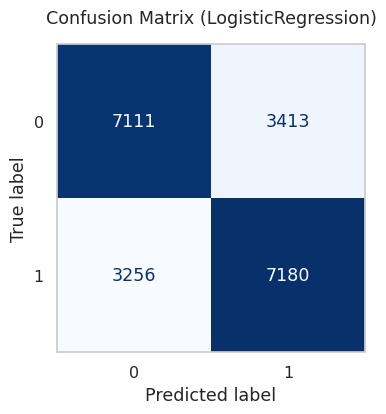

In [18]:
from sklearn.linear_model import LogisticRegression
from optuna.distributions import FloatDistribution, CategoricalDistribution

# Definimos hiperparámetros a probar
param_dist_lr = {
    'C': FloatDistribution(1e-3, 1e3, log=True),
    'penalty': CategoricalDistribution(['l1', 'l2']),
    'solver': CategoricalDistribution(['liblinear']),
    'class_weight': CategoricalDistribution(['balanced', None])
}

lr_model = LogisticRegression(max_iter=MAX_ITER, random_state=RND)

# Entrenamos con Optuna (le damos 250 intentos)
grid_log = ejecutar_modelo(
    lr_model, 
    param_dist_lr, 
    X_train, 
    y_train,
    tipo_busqueda='optuna',
    n_iter=250
)

best_lr = grid_log.best_estimator_

---

## A.2 - K-Nearest Neighbors (KNN)


--- Iniciando entrenamiento de KNeighborsClassifier ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

Mejores Parámetros (KNeighborsClassifier): {'clf__n_neighbors': 29, 'clf__weights': 'distance', 'clf__p': 2}
>>> Best Time-Series CV ACCURACY: 0.6773
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


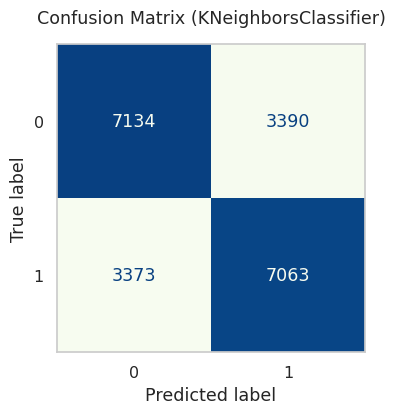

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from optuna.distributions import IntDistribution, CategoricalDistribution

# Hiperparámetros (solo vecinos impares)
param_dist_knn = {
    'n_neighbors': IntDistribution(1, 29, step=2),
    'weights': CategoricalDistribution(['uniform', 'distance']),
    'p': CategoricalDistribution([1, 2])
}

knn_model = KNeighborsClassifier()

# Entrenar
grid_knn = ejecutar_modelo(
    knn_model, 
    param_dist_knn, 
    X_train, 
    y_train,
    tipo_busqueda='optuna',
    n_iter=1000
)

best_knn = grid_knn.best_estimator_

---

## A.3 - SVM lineal


--- Iniciando entrenamiento de LinearSVC ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

Mejores Parámetros (LinearSVC): {'clf__C': 0.0011939725206334738, 'clf__loss': 'squared_hinge', 'clf__fit_intercept': True, 'clf__class_weight': None}
>>> Best Time-Series CV ACCURACY: 0.6802
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


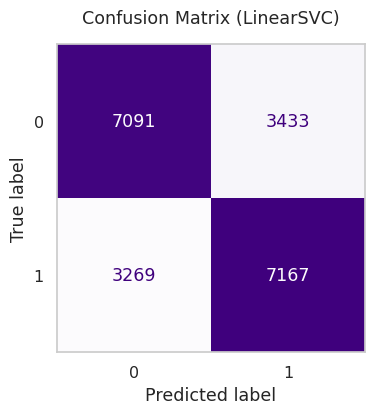

In [20]:
from sklearn.svm import LinearSVC
from optuna.distributions import FloatDistribution, CategoricalDistribution

# Hiperparámetros
param_dist_svm = {
    'C': FloatDistribution(1e-3, 1e3, log=True),
    'loss': CategoricalDistribution(['squared_hinge']), 
    'fit_intercept': CategoricalDistribution([True, False]),
    'class_weight': CategoricalDistribution([None, 'balanced'])
}

svm_model = LinearSVC(dual=False, random_state=RND, max_iter=MAX_ITER)

# Entrenar
grid_svm = ejecutar_modelo(
    svm_model, 
    param_dist_svm, 
    X_train, 
    y_train,
    tipo_busqueda='optuna',
    n_iter=1000
)

best_svm = grid_svm.best_estimator_

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase B: Modelos no líneales

## B.1 - Random Forest


--- Iniciando entrenamiento de RandomForestClassifier ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

Mejores Parámetros (RandomForestClassifier): {'clf__n_estimators': 190, 'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_leaf': 2}
>>> Best Time-Series CV ACCURACY: 0.6946
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


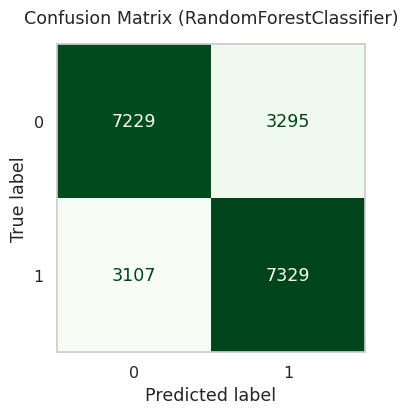

In [21]:
from sklearn.ensemble import RandomForestClassifier
from optuna.distributions import IntDistribution, CategoricalDistribution

# Hiperparámetros
param_dist_rf = {
    'n_estimators': IntDistribution(10, 300, log=True),
    'criterion': CategoricalDistribution(['gini', 'entropy']),
    'max_depth': IntDistribution(1, 30),
    'min_samples_leaf': IntDistribution(1, 15)
}

rf_model = RandomForestClassifier(random_state=RND, n_jobs=4)

# Entrenar (tarda un poco)
grid_rf = ejecutar_modelo(
    rf_model, 
    param_dist_rf, 
    X_train, 
    y_train,
    tipo_busqueda='optuna',
    n_iter=250
)

best_rf = grid_rf.best_estimator_

---

## B.2 - XGBoost


--- Iniciando entrenamiento de XGBClassifier ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

Mejores Parámetros (XGBClassifier): {'clf__n_estimators': 277, 'clf__learning_rate': 0.01948536502020252, 'clf__max_depth': 7, 'clf__subsample': 0.8871425493943002, 'clf__colsample_bytree': 0.9543002244770743, 'clf__gamma': 3.7879065150316134, 'clf__reg_alpha': 0.02625846275027304, 'clf__reg_lambda': 0.00024528257383697}
>>> Best Time-Series CV ACCURACY: 0.7076
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


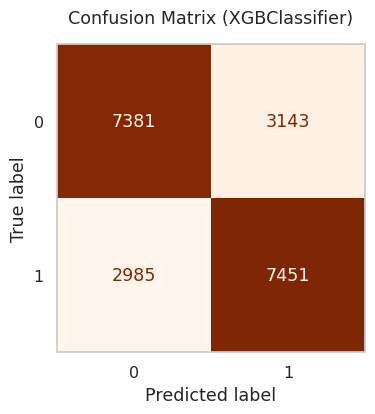

In [22]:
from xgboost import XGBClassifier
from optuna.distributions import FloatDistribution, IntDistribution

# Hiperparámetros a buscar
param_dist_xgb = {
    'n_estimators': IntDistribution(100, 600), 
    'learning_rate': FloatDistribution(0.005, 0.3, log=True), 
    'max_depth': IntDistribution(3, 10),
    'subsample': FloatDistribution(0.5, 1.0),
    'colsample_bytree': FloatDistribution(0.5, 1.0),
    'gamma': FloatDistribution(0, 5.0),
    'reg_alpha': FloatDistribution(1e-8, 10.0, log=True), 
    'reg_lambda': FloatDistribution(1e-8, 10.0, log=True) 
}

# Configuramos XGBoost (optimizado para CPU)
xgb_model = XGBClassifier(
    random_state=RND, 
    n_jobs=1,
    objective='binary:logistic', 
    eval_metric='logloss',
    device='cpu',
    tree_method='hist',
    enable_categorical=True
)

# Entrenar (tarda bastante, le damos 500 intentos)
grid_xgb = ejecutar_modelo(
    xgb_model, 
    param_dist_xgb, 
    X_train, 
    y_train,
    tipo_busqueda='optuna', 
    n_iter=500 
)

best_xgb = grid_xgb.best_estimator_

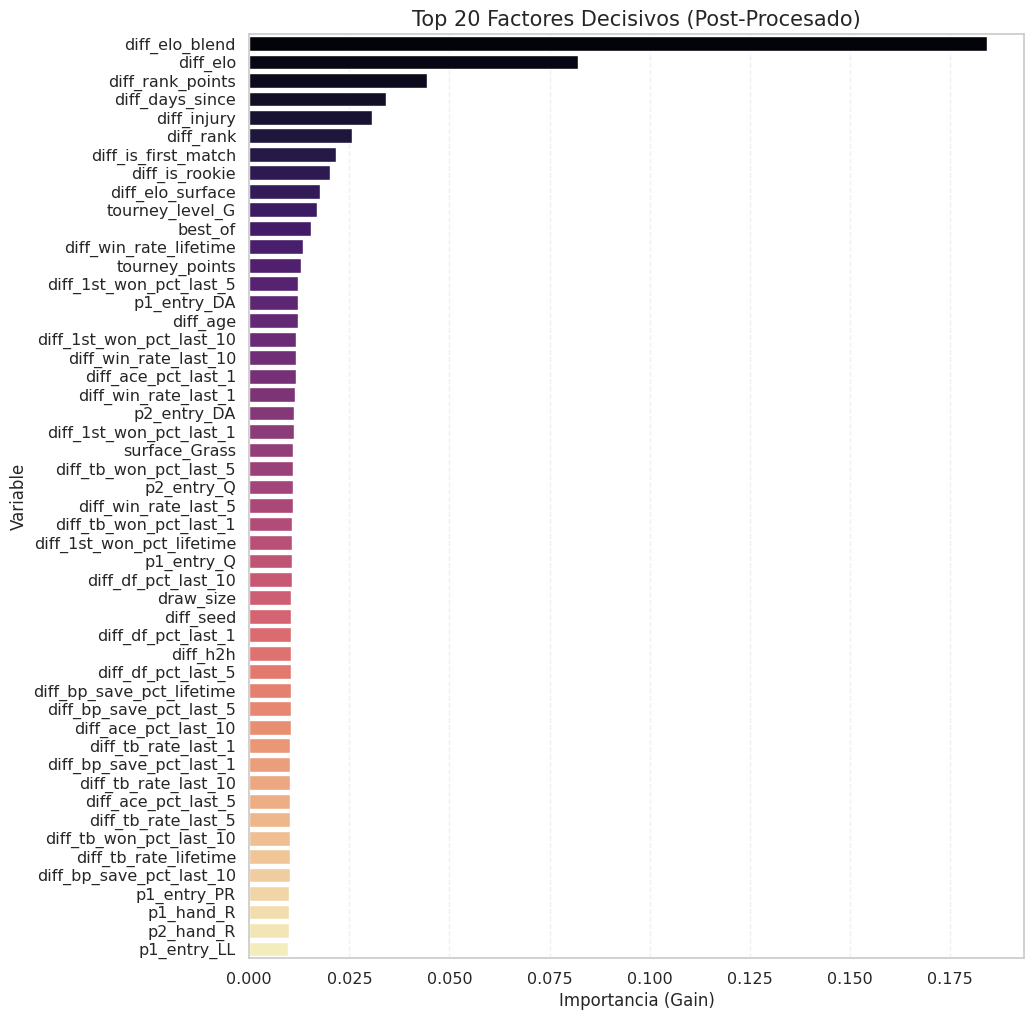

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extraemos el modelo y preprocesador del pipeline
xgboost_puro = best_xgb.named_steps['clf']
preprocessor = best_xgb.named_steps['preprocessor']

# Sacamos las importancias
importances = xgboost_puro.feature_importances_

# Conseguimos los nombres de features (post-encoding)
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    print("No se pudieron extraer nombres. Usando genéricos.")
    feature_names = [f"Feature_{i}" for i in range(len(importances))]

# Creamos DataFrame
df_imp = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances
})

# Top 50 más importantes
df_imp = df_imp.sort_values('Importance', ascending=False).head(50)

plt.figure(figsize=(10, 12))
sns.barplot(data=df_imp, x='Importance', y='Feature', palette='magma')

plt.title('Top 20 Factores Decisivos (Post-Procesado)', fontsize=15)
plt.xlabel('Importancia (Gain)', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()

---

## B.3 - Redes neuronales (MLP)


--- Iniciando entrenamiento de MLPClassifier ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

Mejores Parámetros (MLPClassifier): {'clf__hidden_layer_sizes': (50, 25), 'clf__activation': 'relu', 'clf__alpha': 0.04905193768365672, 'clf__learning_rate_init': 0.0033558656680916024, 'clf__batch_size': 64}
>>> Best Time-Series CV ACCURACY: 0.6988
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


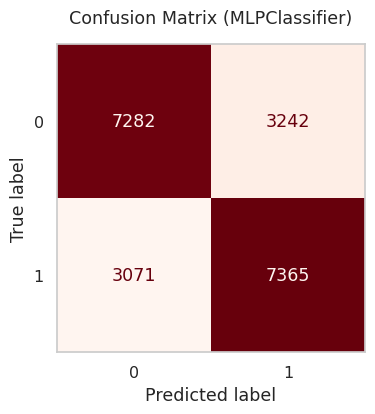

In [24]:
from sklearn.neural_network import MLPClassifier
from optuna.distributions import FloatDistribution, CategoricalDistribution

# Configuración del modelo
mlp_model = MLPClassifier(
    max_iter=1000, 
    early_stopping=True,
    n_iter_no_change=10, 
    validation_fraction=0.1, 
    random_state=RND
)

# Hiperparámetros (probamos diferentes arquitecturas)
param_dist_mlp = {
    'hidden_layer_sizes': CategoricalDistribution([
        (32, 16),
        (50, 25),
        (64, 32),
        (32, 32),
        (32, 16, 8)
    ]),
    'activation': CategoricalDistribution(['relu', 'tanh']),
    'alpha': FloatDistribution(0.001, 0.1, log=True),
    'learning_rate_init': FloatDistribution(0.001, 0.01, log=True),
    'batch_size': CategoricalDistribution([64, 128, 256])
}

# Entrenar
grid_mlp = ejecutar_modelo(
    mlp_model, 
    param_dist_mlp, 
    X_train, 
    y_train, 
    tipo_busqueda='optuna', 
    n_iter=150  
)

best_mlp = grid_mlp.best_estimator_

---

## B.4 - SVM con kernel


--- Iniciando entrenamiento de Pipeline ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

Mejores Parámetros (Pipeline): {'clf__nystroem__gamma': 0.007948308008874933, 'clf__nystroem__n_components': 921, 'clf__clf__alpha': 2.2691716357774674e-05, 'clf__clf__penalty': 'elasticnet'}
>>> Best Time-Series CV ACCURACY: 0.6987
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


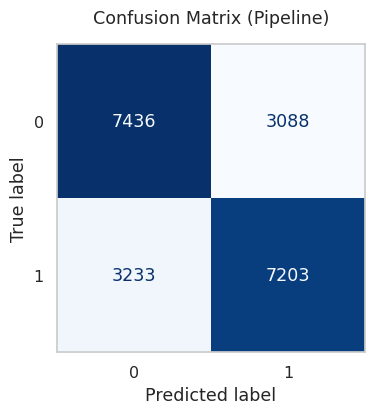

In [25]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

# Pipeline especial: Nystroem aproxima el kernel RBF rápidamente
model_approx = Pipeline([
    ('nystroem', Nystroem(kernel='rbf', random_state=RND)),
    ('clf', SGDClassifier(loss='log_loss', random_state=RND, n_jobs=1))
])

# Hiperparámetros
param_dist_approx = {
    'nystroem__gamma': FloatDistribution(0.001, 1.0, log=True),
    'nystroem__n_components': IntDistribution(100, 1000),
    'clf__alpha': FloatDistribution(1e-5, 1e-1, log=True),
    'clf__penalty': CategoricalDistribution(['l2', 'l1', 'elasticnet'])
}

# Entrenar
grid_svm_fast = ejecutar_modelo(
    model_approx, 
    param_dist_approx, 
    X_train, y_train, 
    tipo_busqueda='optuna', 
    n_iter=250
)

best_svm_fast = grid_svm_fast.best_estimator_

---

## B.5 - Ensamble (Voting y Stacking)


--- Iniciando entrenamiento de VotingClassifier ---
Modo: RANDOM search | CV: TimeSeriesSplit (5 splits)
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Mejores Parámetros (VotingClassifier): {'clf__weights': [1, 1, 1, 2, 2, 2, 1]}
>>> Best Time-Series CV ACCURACY: 0.7046
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


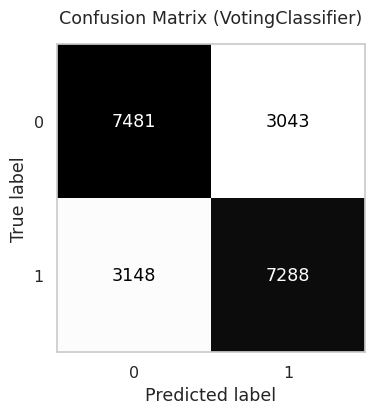

In [26]:
from sklearn.ensemble import VotingClassifier

# Extraemos los clasificadores de los pipelines
estimators_list = [
    ('lr', best_lr.named_steps['clf']),
    ('knn', best_knn.named_steps['clf']),
    ('svc', best_svm.named_steps['clf']),
    ('rf', best_rf.named_steps['clf']),
    ('xgb', best_xgb.named_steps['clf']),
    ('mlp', best_mlp.named_steps['clf']),
    ('svm_k', best_svm_fast.named_steps['clf'])
]

voting_model = VotingClassifier(
    estimators=estimators_list,
    voting='hard', 
    n_jobs=1
)

# Probamos diferentes pesos
param_grid_voting = {
    'weights': [
        [1, 1, 1, 1, 1, 1, 1],
        [2, 1, 1, 1, 1, 1, 1],
        [1, 2, 1, 1, 1, 1, 1],
        [1, 1, 2, 1, 1, 1, 1],
        [1, 1, 1, 2, 1, 1, 1],
        [1, 1, 1, 1, 2, 1, 1],
        [1, 1, 1, 1, 1, 2, 1],
        [2, 1, 1, 2, 2, 1, 1],
        [1, 1, 1, 2, 2, 2, 1],
    ],
}

grid_voting = ejecutar_modelo(
    voting_model, 
    param_grid_voting, 
    X_train,  
    y_train,
    tipo_busqueda='random',
    n_iter=25
)

best_voting = grid_voting.best_estimator_


--- Iniciando entrenamiento de VotingClassifier ---
Modo: RANDOM search | CV: TimeSeriesSplit (5 splits)
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Mejores Parámetros (VotingClassifier): {'clf__weights': [2, 1, 1]}
>>> Best Time-Series CV ACCURACY: 0.7058
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


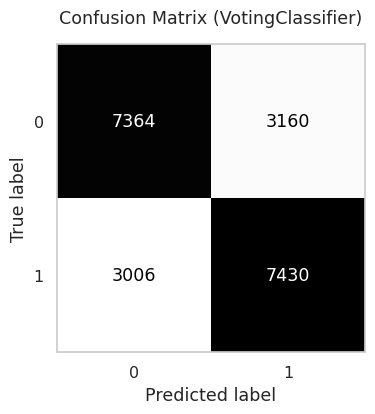

In [27]:
from sklearn.ensemble import VotingClassifier

# Versión optimizada: solo los 3 mejores
estimators_list = [
    ('xgb', best_xgb.named_steps['clf']),
    ('mlp', best_mlp.named_steps['clf']),
    ('lr', best_lr.named_steps['clf'])
]

voting_model = VotingClassifier(
    estimators=estimators_list,
    voting='soft',
    n_jobs=1 
)

# Probamos pesos favoreciendo XGBoost
param_grid_voting = {
    'weights': [
        [1, 1, 1],
        [2, 1, 1],
        [3, 2, 1],
        [2, 2, 1],
    ],
}

grid_voting_top3 = ejecutar_modelo(
    voting_model, 
    param_grid_voting, 
    X_train,  
    y_train,
    tipo_busqueda='random',
    n_iter=20
)

best_voting_top3 = grid_voting.best_estimator_


--- Iniciando entrenamiento de StackingClassifier ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

Mejores Parámetros (StackingClassifier): {'clf__final_estimator__C': 20.284209003887714, 'clf__passthrough': False}
>>> Best Time-Series CV ACCURACY: 0.7060
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


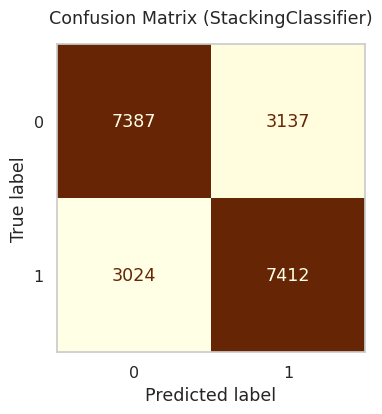

In [28]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from optuna.distributions import FloatDistribution, CategoricalDistribution

# Modelos base (los 3 mejores)
estimators_stack = [
    ('xgb', best_xgb.named_steps['clf']),
    ('mlp', best_mlp.named_steps['clf']),
    ('lr', best_lr.named_steps['clf'])
]

# Stacking: un meta-modelo aprende a combinar las predicciones
stacking_model = StackingClassifier(
    estimators=estimators_stack,
    final_estimator=LogisticRegression(max_iter=2000),
    cv=5, 
    stack_method='predict_proba',
    n_jobs=1
)

# Hiperparámetros del meta-modelo
param_dist_stack = {
    'final_estimator__C': FloatDistribution(1e-3, 1e2, log=True),
    'passthrough': CategoricalDistribution([True, False])
}

# Entrenar
grid_stacking_opt = ejecutar_modelo(
    stacking_model, 
    param_dist_stack, 
    X_train,  
    y_train,
    tipo_busqueda='optuna',
    n_iter=15
)

best_stacking_top3 = grid_stacking_opt.best_estimator_

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Parte 3 - Comparación de los modelos

## Introducción

Aquí vamos a comparar todos los modelos que hemos entrenado para ver cuál funciona mejor.

**Criterios de evaluación:**
- **Principal**: Score de CV (validación cruzada)
- **Secundario**: Score en test (para ver si generaliza bien)
- **Overfitting**: Diferencia entre CV y Test

**Clasificación:**
- **Modelos simples**: Regresión logística, SVM lineal, K-NN
- **Modelos complejos**: Random Forest, XGBoost, MLP
- **Ensemble**: Voting y Stacking

## 3.1 - Resumen de todos los modelos

Primero recopilamos todos los resultados en una tabla.

In [29]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Todos los modelos entrenados
models_dict = {
    'Logistic Regression': grid_log,
    'Linear SVM': grid_svm,
    'K-Nearest Neighbors': grid_knn,
    'Random Forest': grid_rf,
    'XGBoost': grid_xgb,
    'MLP (Neural Network)': grid_mlp,
    'Voting Ensemble': grid_voting,
    'best_voting_top3': grid_voting_top3,
    'SVM with Kernel': grid_svm_fast,
    'best_stacking_top3': grid_stacking_opt
}

# Clasificación
linear_models = ['Logistic Regression', 'Linear SVM', 'K-Nearest Neighbors']
nonlinear_models = ['Random Forest', 'XGBoost', 'MLP (Neural Network)']
ensemble_models = ['Voting Ensemble', 'Stacking Ensemble']

# Recopilamos resultados
results = []
for name, grid in models_dict.items():
    cv_score = grid.best_score_
    
    # Predecir en test
    y_pred_test = grid.best_estimator_.predict(X_test)
    test_score = accuracy_score(y_test, y_pred_test)
    
    # Diferencia (para overfitting)
    diff = cv_score - test_score
    
    # Tipo de modelo
    if name in linear_models:
        model_type = 'Linear'
    elif name in nonlinear_models:
        model_type = 'Non-Linear'
    else:
        model_type = 'Ensemble'
    
    results.append({
        'Modelo': name,
        'Tipo': model_type,
        'CV Score': cv_score,
        'Test Score': test_score,
        'Diferencia (CV - Test)': diff
    })

# DataFrame
df_results = pd.DataFrame(results).sort_values('CV Score', ascending=False)

print("RESUMEN DE TODOS LOS MODELOS:")
display(df_results.style.background_gradient(cmap='RdYlGn', subset=['CV Score', 'Test Score'])
                        .format({'CV Score': '{:.4f}', 'Test Score': '{:.4f}', 'Diferencia (CV - Test)': '{:.4f}'}))

RESUMEN DE TODOS LOS MODELOS:


## 3.2 - Comparación de Modelos Lineales

Vamos a comparar en detalle los modelos más básicos.

MODELOS LINEALES:


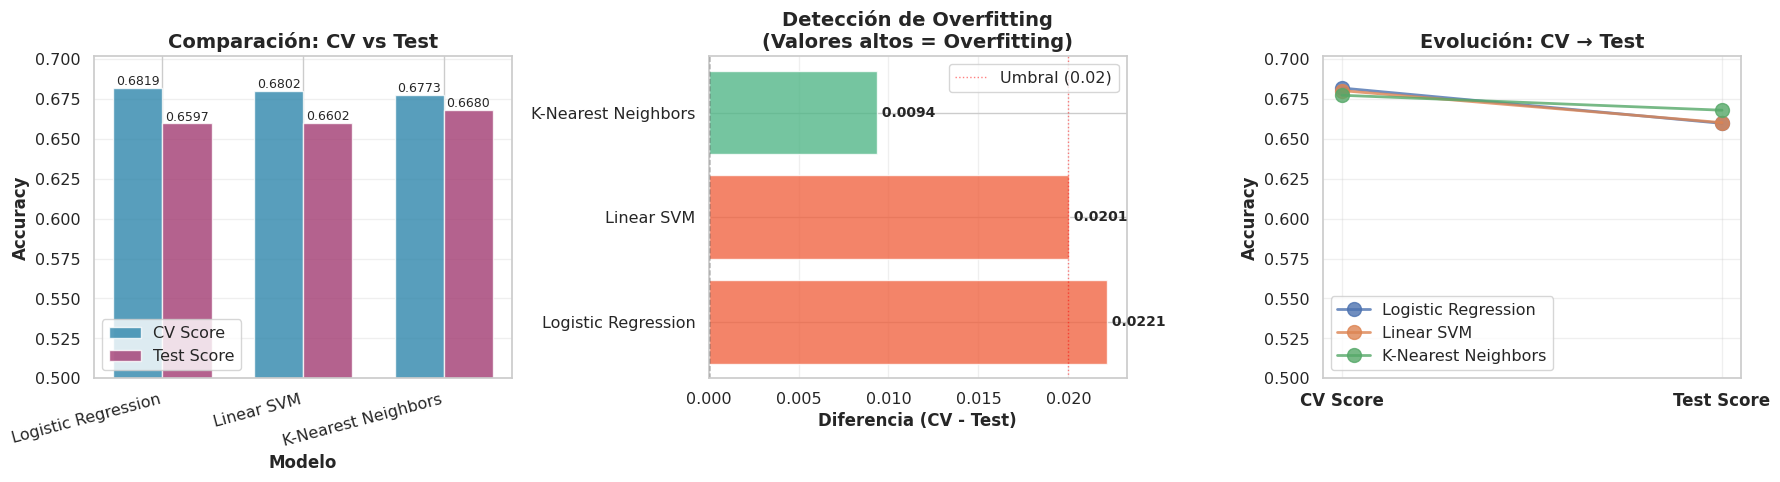

MEJOR MODELO LINEAL: Logistic Regression
   CV Score:   0.6819
   Test Score: 0.6597
   Diferencia: 0.0221



In [30]:
# Filtramos modelos lineales
df_linear = df_results[df_results['Tipo'] == 'Linear'].copy()

print("MODELOS LINEALES:")
display(df_linear.style.background_gradient(cmap='RdYlGn', subset=['CV Score', 'Test Score'])
                       .format({'CV Score': '{:.4f}', 'Test Score': '{:.4f}', 'Diferencia (CV - Test)': '{:.4f}'}))

# Gráficos comparativos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: CV vs Test
x = np.arange(len(df_linear))
width = 0.35

bars1 = axes[0].bar(x - width/2, df_linear['CV Score'], width, label='CV Score', alpha=0.8, color='#2E86AB')
bars2 = axes[0].bar(x + width/2, df_linear['Test Score'], width, label='Test Score', alpha=0.8, color='#A23B72')

axes[0].set_xlabel('Modelo', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Comparación: CV vs Test', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_linear['Modelo'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.5, max(df_linear['CV Score'].max(), df_linear['Test Score'].max()) + 0.02])

# Añadimos valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Gráfico 2: Overfitting
colors = ['#F06543' if x > 0.02 else '#52B788' for x in df_linear['Diferencia (CV - Test)']]
axes[1].barh(df_linear['Modelo'], df_linear['Diferencia (CV - Test)'], color=colors, alpha=0.8)
axes[1].set_xlabel('Diferencia (CV - Test)', fontsize=12, fontweight='bold')
axes[1].set_title('Detección de Overfitting\n(Valores altos = Overfitting)', fontsize=14, fontweight='bold')
axes[1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1].axvline(0.02, color='red', linestyle=':', linewidth=1, alpha=0.5, label='Umbral (0.02)')
axes[1].grid(axis='x', alpha=0.3)
axes[1].legend()

# Añadir valores en las barras
for i, (idx, row) in enumerate(df_linear.iterrows()):
    axes[1].text(row['Diferencia (CV - Test)'], i, f" {row['Diferencia (CV - Test)']:.4f}", 
                va='center', fontsize=10, fontweight='bold')

# 3. Evolución CV -> Test
x_pos = np.arange(2)  # CV Score, Test Score
for i, (idx, row) in enumerate(df_linear.iterrows()):
    scores = [row['CV Score'], row['Test Score']]
    axes[2].plot(x_pos, scores, marker='o', markersize=10, linewidth=2, label=row['Modelo'], alpha=0.8)
    
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(['CV Score', 'Test Score'], fontsize=12, fontweight='bold')
axes[2].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[2].set_title('Evolución: CV → Test', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)
axes[2].set_ylim([0.5, max(df_linear['CV Score'].max(), df_linear['Test Score'].max()) + 0.02])

plt.tight_layout()
plt.show()

# Mejor modelo lineal
best_linear = df_linear.iloc[0]
print(f"MEJOR MODELO LINEAL: {best_linear['Modelo']}")
print(f"   CV Score:   {best_linear['CV Score']:.4f}")
print(f"   Test Score: {best_linear['Test Score']:.4f}")
print(f"   Diferencia: {best_linear['Diferencia (CV - Test)']:.4f}")
print(f"{'='*80}\n")

### Evaluación detallada del mejor modelo lineal

Classification Report - Logistic Regression (Test Set)
               precision    recall  f1-score   support

Player 2 Wins       0.66      0.65      0.65      5421
Player 1 Wins       0.66      0.67      0.66      5500

     accuracy                           0.66     10921
    macro avg       0.66      0.66      0.66     10921
 weighted avg       0.66      0.66      0.66     10921



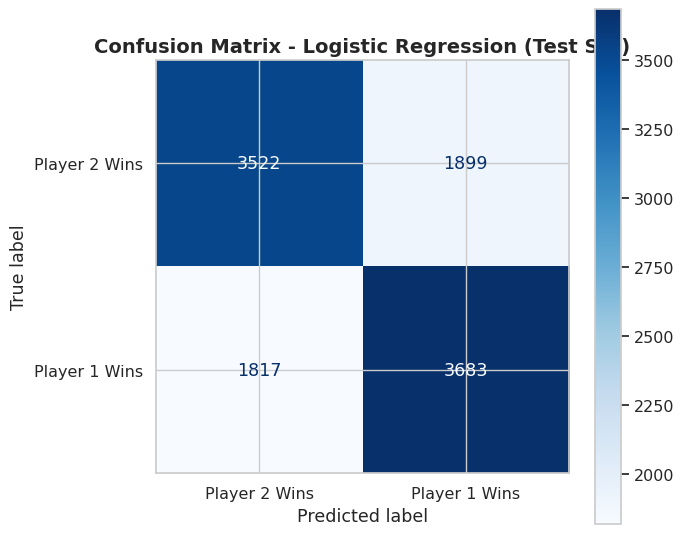

In [31]:
# Obtener el mejor modelo lineal
best_linear_name = best_linear['Modelo']
best_linear_grid = models_dict[best_linear_name]
y_pred_test = best_linear_grid.best_estimator_.predict(X_test)

print(f"Classification Report - {best_linear_name} (Test Set)")
print(classification_report(y_test, y_pred_test, target_names=['Player 2 Wins', 'Player 1 Wins']))

# Matriz de confusión
fig, ax = plt.subplots(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues', ax=ax, 
                                        display_labels=['Player 2 Wins', 'Player 1 Wins'], values_format='d')
ax.set_title(f'Confusion Matrix - {best_linear_name} (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.3 - Comparación de Modelos No Lineales

Ahora miramos los modelos no lineales en detalle.

MODELOS NO LINEALES:


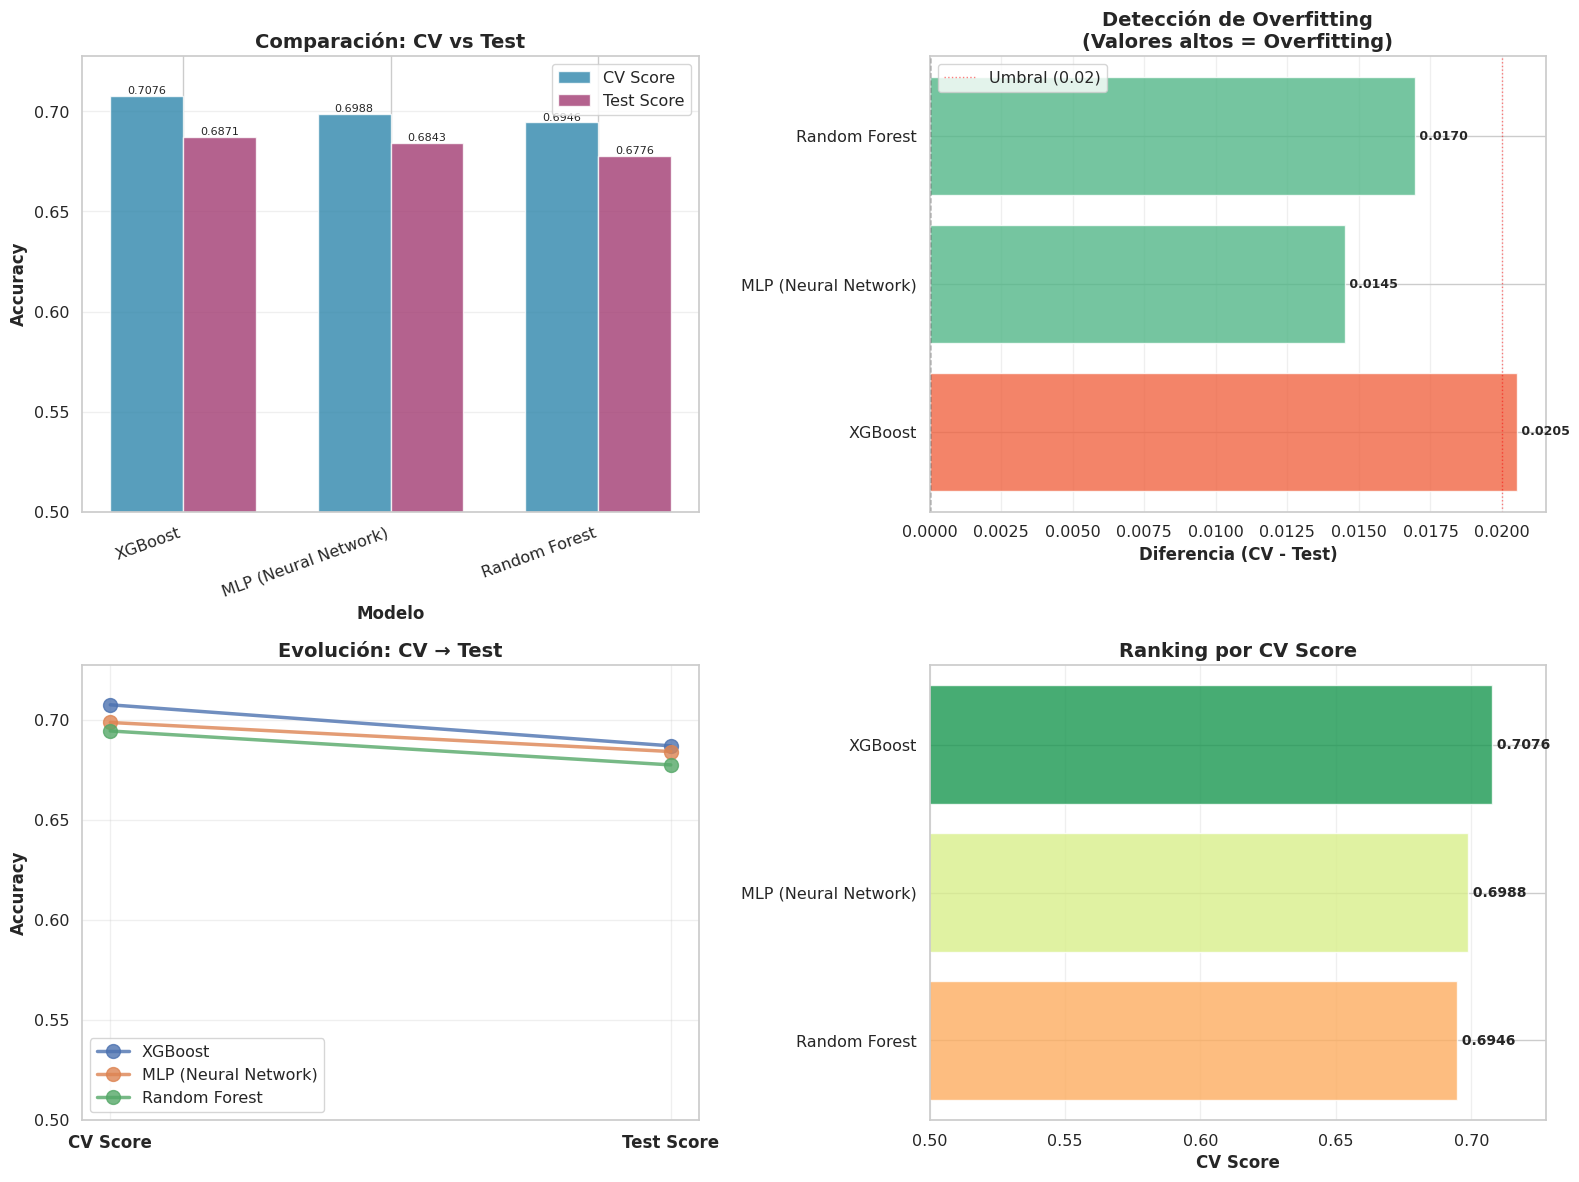

MEJOR MODELO NO LINEAL: XGBoost
   CV Score:   0.7076
   Test Score: 0.6871
   Diferencia: 0.0205



In [32]:
# Filtramos modelos complejos
df_nonlinear = df_results[df_results['Tipo'] == 'Non-Linear'].copy()

print("MODELOS NO LINEALES:")
display(df_nonlinear.style.background_gradient(cmap='RdYlGn', subset=['CV Score', 'Test Score'])
                          .format({'CV Score': '{:.4f}', 'Test Score': '{:.4f}', 'Diferencia (CV - Test)': '{:.4f}'}))

# Gráficos comparativos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. CV vs Test
x = np.arange(len(df_nonlinear))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, df_nonlinear['CV Score'], width, label='CV Score', alpha=0.8, color='#2E86AB')
bars2 = axes[0, 0].bar(x + width/2, df_nonlinear['Test Score'], width, label='Test Score', alpha=0.8, color='#A23B72')

axes[0, 0].set_xlabel('Modelo', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Comparación: CV vs Test', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(df_nonlinear['Modelo'], rotation=20, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0.5, max(df_nonlinear['CV Score'].max(), df_nonlinear['Test Score'].max()) + 0.02])

# Añadir valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.4f}', ha='center', va='bottom', fontsize=8, rotation=0)

# 2. Overfitting
colors = ['#F06543' if x > 0.02 else '#52B788' for x in df_nonlinear['Diferencia (CV - Test)']]
axes[0, 1].barh(df_nonlinear['Modelo'], df_nonlinear['Diferencia (CV - Test)'], color=colors, alpha=0.8)
axes[0, 1].set_xlabel('Diferencia (CV - Test)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Detección de Overfitting\n(Valores altos = Overfitting)', fontsize=14, fontweight='bold')
axes[0, 1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[0, 1].axvline(0.02, color='red', linestyle=':', linewidth=1, alpha=0.5, label='Umbral (0.02)')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].legend()

# Añadir valores
for i, (idx, row) in enumerate(df_nonlinear.iterrows()):
    axes[0, 1].text(row['Diferencia (CV - Test)'], i, f" {row['Diferencia (CV - Test)']:.4f}", 
                   va='center', fontsize=9, fontweight='bold')

# 3. Evolución CV -> Test
x_pos = np.arange(2)
for i, (idx, row) in enumerate(df_nonlinear.iterrows()):
    scores = [row['CV Score'], row['Test Score']]
    axes[1, 0].plot(x_pos, scores, marker='o', markersize=10, linewidth=2.5, label=row['Modelo'], alpha=0.8)
    
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(['CV Score', 'Test Score'], fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Evolución: CV → Test', fontsize=14, fontweight='bold')
axes[1, 0].legend(loc='best')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_ylim([0.5, max(df_nonlinear['CV Score'].max(), df_nonlinear['Test Score'].max()) + 0.02])

# 4. Ranking
sorted_df = df_nonlinear.sort_values('CV Score', ascending=True)
colors_rank = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(sorted_df)))
axes[1, 1].barh(sorted_df['Modelo'], sorted_df['CV Score'], color=colors_rank, alpha=0.8)
axes[1, 1].set_xlabel('CV Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Ranking por CV Score', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].set_xlim([0.5, max(sorted_df['CV Score']) + 0.02])

# Añadir valores
for i, (idx, row) in enumerate(sorted_df.iterrows()):
    axes[1, 1].text(row['CV Score'], i, f" {row['CV Score']:.4f}", 
                   va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Mejor modelo complejo
best_nonlinear = df_nonlinear.iloc[0]
print(f"MEJOR MODELO NO LINEAL: {best_nonlinear['Modelo']}")
print(f"   CV Score:   {best_nonlinear['CV Score']:.4f}")
print(f"   Test Score: {best_nonlinear['Test Score']:.4f}")
print(f"   Diferencia: {best_nonlinear['Diferencia (CV - Test)']:.4f}")
print(f"{'='*80}\n")

### Evaluación detallada del mejor modelo no lineal

Classification Report - XGBoost (Test Set)
               precision    recall  f1-score   support

Player 2 Wins       0.68      0.68      0.68      5421
Player 1 Wins       0.69      0.69      0.69      5500

     accuracy                           0.69     10921
    macro avg       0.69      0.69      0.69     10921
 weighted avg       0.69      0.69      0.69     10921



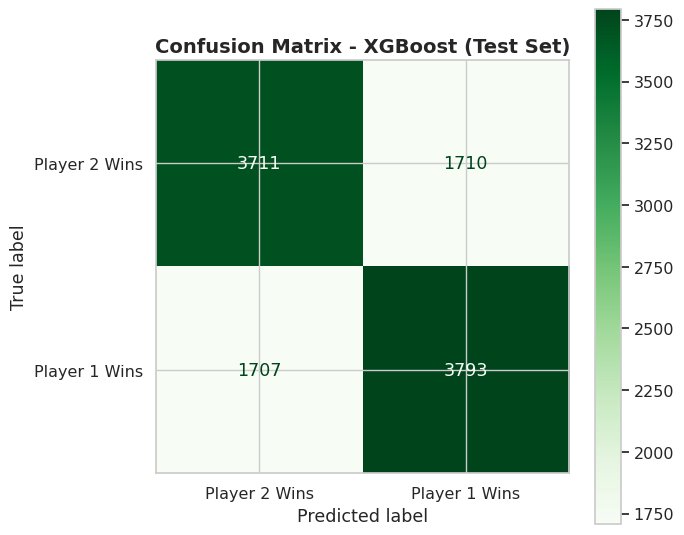

In [33]:
# El mejor modelo complejo
best_nonlinear_name = best_nonlinear['Modelo']
best_nonlinear_grid = models_dict[best_nonlinear_name]
y_pred_test_nl = best_nonlinear_grid.best_estimator_.predict(X_test)

print(f"Classification Report - {best_nonlinear_name} (Test Set)")
print(classification_report(y_test, y_pred_test_nl, target_names=['Player 2 Wins', 'Player 1 Wins']))

# Matriz de confusión
fig, ax = plt.subplots(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_nl, cmap='Greens', ax=ax,
                                        display_labels=['Player 2 Wins', 'Player 1 Wins'], values_format='d')
ax.set_title(f'Confusion Matrix - {best_nonlinear_name} (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.4 - Comparación global: todos contra todos

Ahora comparamos todos los modelos juntos para ver el ganador.

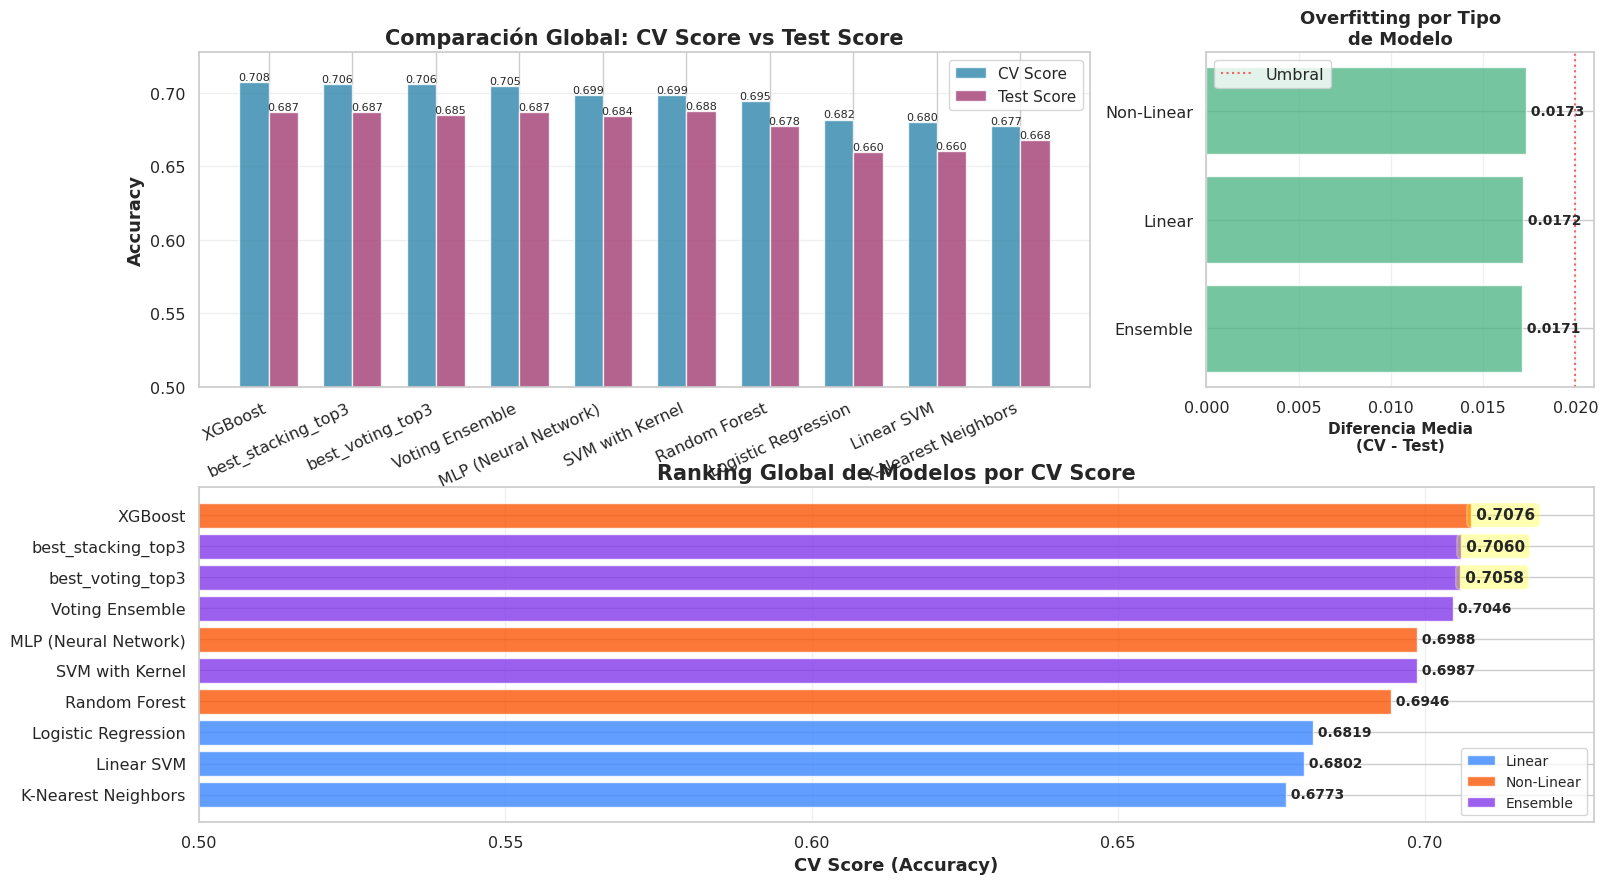

ESTADÍSTICAS POR TIPO DE MODELO:


CV Score                 Test Score                  \
               mean     max     min       mean     max     min   
Tipo                                                             
Ensemble     0.7038  0.7060  0.6987     0.6867  0.6879  0.6847   
Linear       0.6798  0.6819  0.6773     0.6626  0.6680  0.6597   
Non-Linear   0.7003  0.7076  0.6946     0.6830  0.6871  0.6776   

           Diferencia (CV - Test)          
                             mean     max  
Tipo                                       
Ensemble                   0.0171  0.0211  
Linear                     0.0172  0.0221  
Non-Linear                 0.0173  0.0205

In [34]:
# Comparación global
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Todos los modelos CV vs Test
ax1 = fig.add_subplot(gs[0, :2])
x = np.arange(len(df_results))
width = 0.35

bars1 = ax1.bar(x - width/2, df_results['CV Score'], width, label='CV Score', alpha=0.8, color='#2E86AB')
bars2 = ax1.bar(x + width/2, df_results['Test Score'], width, label='Test Score', alpha=0.8, color='#A23B72')

ax1.set_xlabel('Modelo', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax1.set_title('Comparación Global: CV Score vs Test Score', fontsize=15, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_results['Modelo'], rotation=25, ha='right')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.5, max(df_results['CV Score'].max(), df_results['Test Score'].max()) + 0.02])

# Valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Overfitting por tipo
ax2 = fig.add_subplot(gs[0, 2])
tipos = df_results.groupby('Tipo')['Diferencia (CV - Test)'].mean().sort_values()
colors_tipo = ['#52B788' if x < 0.02 else '#F06543' for x in tipos.values]
ax2.barh(tipos.index, tipos.values, color=colors_tipo, alpha=0.8)
ax2.set_xlabel('Diferencia Media\n(CV - Test)', fontsize=11, fontweight='bold')
ax2.set_title('Overfitting por Tipo\nde Modelo', fontsize=13, fontweight='bold')
ax2.axvline(0.02, color='red', linestyle=':', linewidth=1.5, alpha=0.6, label='Umbral')
ax2.grid(axis='x', alpha=0.3)
ax2.legend()

for i, v in enumerate(tipos.values):
    ax2.text(v, i, f' {v:.4f}', va='center', fontsize=10, fontweight='bold')

# 3. Ranking general
ax3 = fig.add_subplot(gs[1, :])
sorted_all = df_results.sort_values('CV Score', ascending=True)

# Colores por tipo
color_map = {'Linear': '#3A86FF', 'Non-Linear': '#FB5607', 'Ensemble': '#8338EC'}
colors_all = [color_map[t] for t in sorted_all['Tipo']]

bars = ax3.barh(sorted_all['Modelo'], sorted_all['CV Score'], color=colors_all, alpha=0.8)
ax3.set_xlabel('CV Score (Accuracy)', fontsize=13, fontweight='bold')
ax3.set_title('Ranking Global de Modelos por CV Score', fontsize=15, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
ax3.set_xlim([0.5, max(sorted_all['CV Score']) + 0.02])

# Valores y destacar top 3
for i, (idx, row) in enumerate(sorted_all.iterrows()):
    text = f" {row['CV Score']:.4f}"
    if i >= len(sorted_all) - 3:
        ax3.text(row['CV Score'], i, text, va='center', fontsize=11, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
    else:
        ax3.text(row['CV Score'], i, text, va='center', fontsize=10, fontweight='bold')

# Leyenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[tipo], alpha=0.8, label=tipo) 
                  for tipo in ['Linear', 'Non-Linear', 'Ensemble']]
ax3.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

print("ESTADÍSTICAS POR TIPO DE MODELO:")
stats_by_type = df_results.groupby('Tipo').agg({
    'CV Score': ['mean', 'max', 'min'],
    'Test Score': ['mean', 'max', 'min'],
    'Diferencia (CV - Test)': ['mean', 'max']
}).round(4)
display(stats_by_type)

## 3.5 - Curvas ROC: Análisis de Discriminación

Las curvas ROC nos ayudan a ver cómo de bien discrimina cada modelo entre las dos clases.

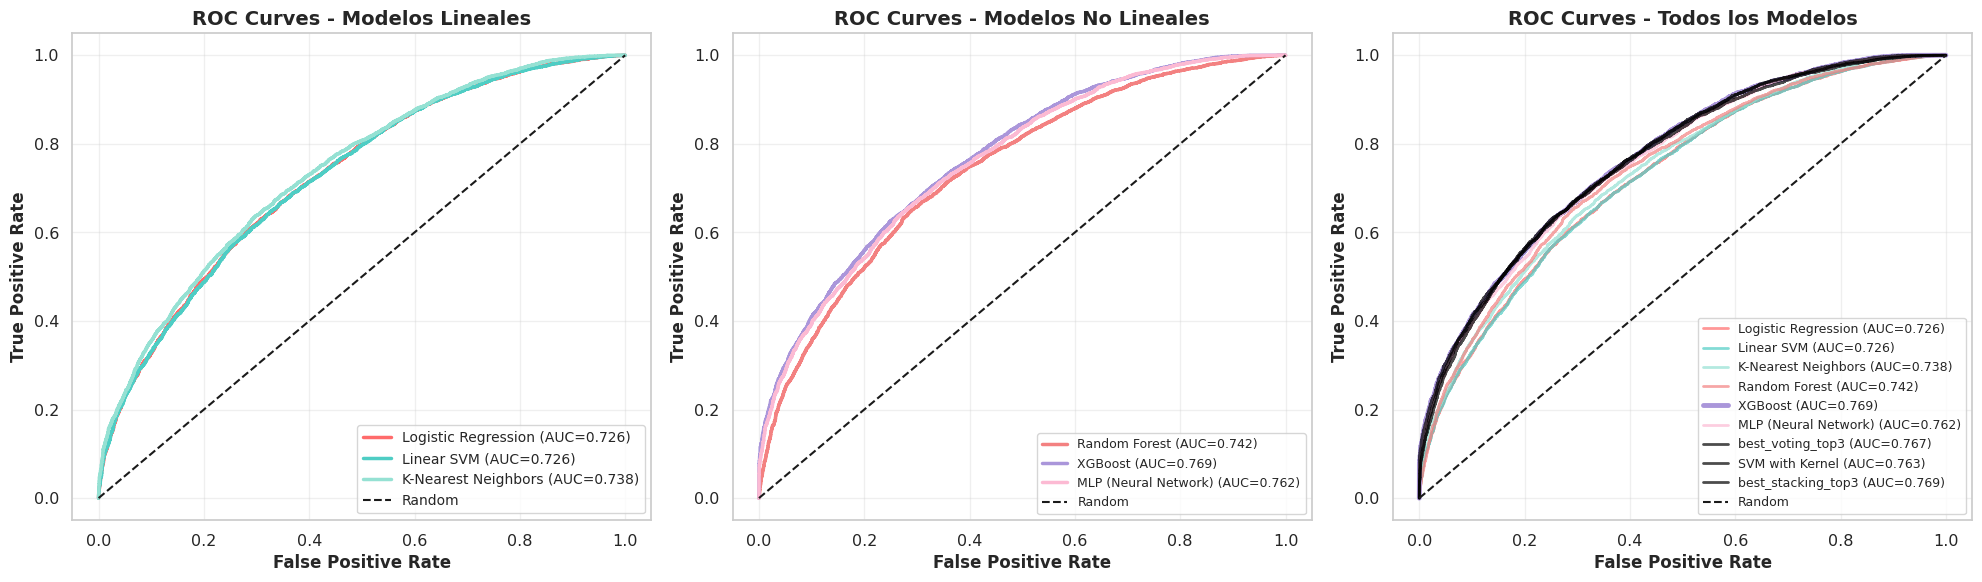

AUC SCORES:


In [35]:
# Curvas ROC por categoría
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Colores para cada modelo
model_colors = {
    'Logistic Regression': '#FF6B6B',
    'Linear SVM': '#4ECDC4',
    'K-Nearest Neighbors': '#95E1D3',
    'Random Forest': '#F38181',
    'XGBoost': '#AA96DA',
    'MLP (Neural Network)': '#FCBAD3',
    'Voting Ensemble': '#FFFFD2'
}

auc_scores = {}

# 1. Modelos simples
for name in linear_models:
    grid = models_dict[name]
    try:
        if hasattr(grid.best_estimator_.named_steps['clf'], 'predict_proba'):
            y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
        elif hasattr(grid.best_estimator_.named_steps['clf'], 'decision_function'):
            y_proba = grid.best_estimator_.decision_function(X_test)
        else:
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        auc_scores[name] = auc
        
        axes[0].plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', 
                    linewidth=2.5, color=model_colors.get(name, 'black'))
    except:
        pass

axes[0].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)
axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_title('ROC Curves - Modelos Lineales', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)

# 2. Modelos complejos
for name in nonlinear_models:
    grid = models_dict[name]
    try:
        if hasattr(grid.best_estimator_.named_steps['clf'], 'predict_proba'):
            y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
        elif hasattr(grid.best_estimator_.named_steps['clf'], 'decision_function'):
            y_proba = grid.best_estimator_.decision_function(X_test)
        else:
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        auc_scores[name] = auc
        
        axes[1].plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', 
                    linewidth=2.5, color=model_colors.get(name, 'black'))
    except:
        pass

axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('ROC Curves - Modelos No Lineales', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=9)
axes[1].grid(alpha=0.3)

# 3. Todos juntos
for name, grid in models_dict.items():
    try:
        if hasattr(grid.best_estimator_.named_steps['clf'], 'predict_proba'):
            y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
        elif hasattr(grid.best_estimator_.named_steps['clf'], 'decision_function'):
            y_proba = grid.best_estimator_.decision_function(X_test)
        else:
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        if name not in auc_scores:
            auc = roc_auc_score(y_test, y_proba)
            auc_scores[name] = auc
        else:
            auc = auc_scores[name]
        
        # Destacar el mejor con línea más gruesa
        lw = 3.5 if name == df_results.iloc[0]['Modelo'] else 2
        alpha = 1.0 if name == df_results.iloc[0]['Modelo'] else 0.7
        
        axes[2].plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', 
                    linewidth=lw, alpha=alpha, color=model_colors.get(name, 'black'))
    except:
        pass

axes[2].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)
axes[2].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[2].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[2].set_title('ROC Curves - Todos los Modelos', fontsize=14, fontweight='bold')
axes[2].legend(loc='lower right', fontsize=9)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla de AUC scores
print("AUC SCORES:")
auc_df = pd.DataFrame(list(auc_scores.items()), columns=['Modelo', 'AUC Score']).sort_values('AUC Score', ascending=False)
display(auc_df.style.background_gradient(cmap='RdYlGn', subset=['AUC Score'])
                   .format({'AUC Score': '{:.4f}'}))

## 3.6 - Modelo ganador

Después de todos los análisis, determinamos el mejor modelo según nuestro criterio.

MEJOR MODELO GLOBAL:
   Modelo:                XGBoost
   Tipo:                  Non-Linear
   CV Score:              0.7076
   Test Score:            0.6871
   Diferencia (CV-Test):  0.0205
   AUC Score:             0.7688


JUSTIFICACIÓN:
1. **CV Score**: Con 0.7076, este modelo superó a los otros 9 modelos.

2. **Test Score**: El score de 0.6871 confirma que generaliza bien.

3. **Overfitting**: Diferencia de 0.0205 entre CV y Test.
   Hay algo de overfitting, pero sigue siendo el mejor en CV.

4. **Ventaja**: Supera a 'best_stacking_top3' por 0.0016 puntos.


EVALUACIÓN COMPLETA - XGBoost (Test Set)
               precision    recall  f1-score   support

Player 2 Wins       0.68      0.68      0.68      5421
Player 1 Wins       0.69      0.69      0.69      5500

     accuracy                           0.69     10921
    macro avg       0.69      0.69      0.69     10921
 weighted avg       0.69      0.69      0.69     10921



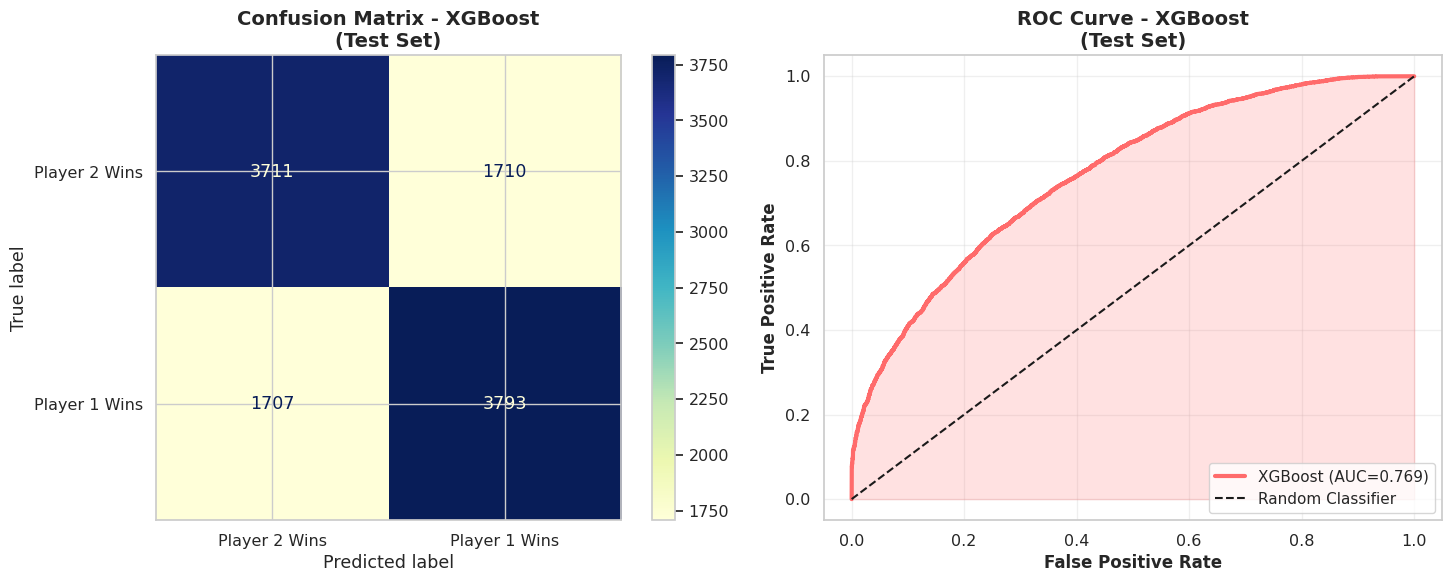

RESUMEN FINAL:

El modelo **XGBoost** es el GANADOR según nuestro criterio de evaluación.
Logró el mejor CV Score (0.7076) y mantiene buen rendimiento en test.
Este modelo será utilizado para las predicciones finales del proyecto.


In [36]:
# El mejor modelo
best_model = df_results.iloc[0]
best_model_name = best_model['Modelo']
best_model_grid = models_dict[best_model_name]
y_pred_best = best_model_grid.best_estimator_.predict(X_test)

# Banner
print("MEJOR MODELO GLOBAL:")

print(f"{'   Modelo:':<25} {best_model_name}")
print(f"{'   Tipo:':<25} {best_model['Tipo']}")
print(f"{'   CV Score:':<25} {best_model['CV Score']:.4f}")
print(f"{'   Test Score:':<25} {best_model['Test Score']:.4f}")
print(f"{'   Diferencia (CV-Test):':<25} {best_model['Diferencia (CV - Test)']:.4f}")
if best_model_name in auc_scores:
    print(f"{'   AUC Score:':<25} {auc_scores[best_model_name]:.4f}")

print("\n" + "=" * 100)

# Por qué este modelo?
print("\nJUSTIFICACIÓN:")
print(f"1. **CV Score**: Con {best_model['CV Score']:.4f}, este modelo superó a los otros {len(df_results)-1} modelos.")
print(f"\n2. **Test Score**: El score de {best_model['Test Score']:.4f} confirma que generaliza bien.")
print(f"\n3. **Overfitting**: Diferencia de {best_model['Diferencia (CV - Test)']:.4f} entre CV y Test.")
if best_model['Diferencia (CV - Test)'] < 0.02:
    print(f"   El modelo **NO tiene overfitting significativo**.")
else:
    print(f"   Hay algo de overfitting, pero sigue siendo el mejor en CV.")

# Comparación con segundo
second_best = df_results.iloc[1]
diff_from_second = best_model['CV Score'] - second_best['CV Score']
print(f"\n4. **Ventaja**: Supera a '{second_best['Modelo']}' por {diff_from_second:.4f} puntos.")

print("\n" + "=" * 100)

# Evaluación completa del ganador
print(f"\nEVALUACIÓN COMPLETA - {best_model_name} (Test Set)")
print(classification_report(y_test, y_pred_best, target_names=['Player 2 Wins', 'Player 1 Wins']))

# Matriz de confusión del ganador
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráficos finales
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, cmap='YlGnBu', ax=axes[0],
                                        display_labels=['Player 2 Wins', 'Player 1 Wins'], values_format='d')
axes[0].set_title(f'Confusion Matrix - {best_model_name}\n(Test Set)', 
                 fontsize=14, fontweight='bold')

# Curva ROC del ganador destacada
if best_model_name in auc_scores:
    try:
        if hasattr(best_model_grid.best_estimator_.named_steps['clf'], 'predict_proba'):
            y_proba_best = best_model_grid.best_estimator_.predict_proba(X_test)[:, 1]
        elif hasattr(best_model_grid.best_estimator_.named_steps['clf'], 'decision_function'):
            y_proba_best = best_model_grid.best_estimator_.decision_function(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_proba_best)
        auc_best = auc_scores[best_model_name]
        
        axes[1].plot(fpr, tpr, linewidth=3, label=f'{best_model_name} (AUC={auc_best:.3f})', color='#FF6B6B')
        axes[1].fill_between(fpr, tpr, alpha=0.2, color='#FF6B6B')
        axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5)
        axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
        axes[1].set_title(f'ROC Curve - {best_model_name}\n(Test Set)', fontsize=14, fontweight='bold')
        axes[1].legend(loc='lower right', fontsize=11)
        axes[1].grid(alpha=0.3)
    except:
        axes[1].text(0.5, 0.5, 'ROC Curve not available', ha='center', va='center', fontsize=12)
        axes[1].set_xlim([0, 1])
        axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Resumen final
print("RESUMEN FINAL:")
print(f"\nEl modelo **{best_model_name}** es el GANADOR según nuestro criterio de evaluación.")
print(f"Logró el mejor CV Score ({best_model['CV Score']:.4f}) y mantiene buen rendimiento en test.")
print(f"Este modelo será utilizado para las predicciones finales del proyecto.")

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Parte 4 - Interpretabilidad de los modelos

En esta sección vamos a analizar qué features son importantes para cada modelo y cómo toman sus decisiones.

## 4.1 - Importancia de features en todos los modelos

Primero vamos a extraer y comparar qué variables consideran más importantes los diferentes modelos.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extraer nombres de features del preprocessor
feature_names = preprocessor.get_feature_names_out()

# Diccionario para guardar importancias
feature_importance_dict = {}

# Modelos con feature_importances_
models_with_importance = {
    'Random Forest': grid_rf,
    'XGBoost': grid_xgb
}

for name, grid in models_with_importance.items():
    clf = grid.best_estimator_.named_steps['clf']
    if hasattr(clf, 'feature_importances_'):
        feature_importance_dict[name] = clf.feature_importances_

# Para regresión logística (coeficientes)
lr_clf = grid_log.best_estimator_.named_steps['clf']
if hasattr(lr_clf, 'coef_'):
    feature_importance_dict['Logistic Regression'] = np.abs(lr_clf.coef_[0])

# Crear DataFrame con todas las importancias
importance_df = pd.DataFrame(feature_importance_dict, index=feature_names)

# Top 20 features más importantes por modelo
print("Top 20 features más importantes por modelo:\n")
for model in importance_df.columns:
    print(f"\n{model}:")
    top_features = importance_df[model].nlargest(20)
    for i, (feat, val) in enumerate(top_features.items(), 1):
        print(f"  {i}. {feat}: {val:.4f}")
    print("-" * 80)

Top 20 features más importantes por modelo:


Random Forest:
  1. diff_rank_points: 0.0730
  2. diff_elo_blend: 0.0724
  3. diff_rank: 0.0663
  4. diff_elo: 0.0649
  5. diff_elo_surface: 0.0641
  6. diff_win_rate_lifetime: 0.0457
  7. diff_seed: 0.0278
  8. diff_1st_won_pct_last_10: 0.0238
  9. diff_bp_save_pct_lifetime: 0.0236
  10. diff_age: 0.0233
  11. diff_1st_won_pct_last_5: 0.0228
  12. diff_injury: 0.0223
  13. diff_1st_won_pct_lifetime: 0.0223
  14. diff_1st_won_pct_last_1: 0.0220
  15. diff_df_pct_last_10: 0.0208
  16. diff_ace_pct_last_1: 0.0202
  17. diff_df_pct_last_1: 0.0201
  18. diff_bp_save_pct_last_1: 0.0200
  19. diff_bp_save_pct_last_5: 0.0199
  20. diff_days_since: 0.0199
--------------------------------------------------------------------------------

XGBoost:
  1. diff_elo_blend: 0.1843
  2. diff_elo: 0.0822
  3. diff_rank_points: 0.0443
  4. diff_days_since: 0.0342
  5. diff_injury: 0.0307
  6. diff_rank: 0.0258
  7. diff_is_first_match: 0.0216
  8. diff_is_rook

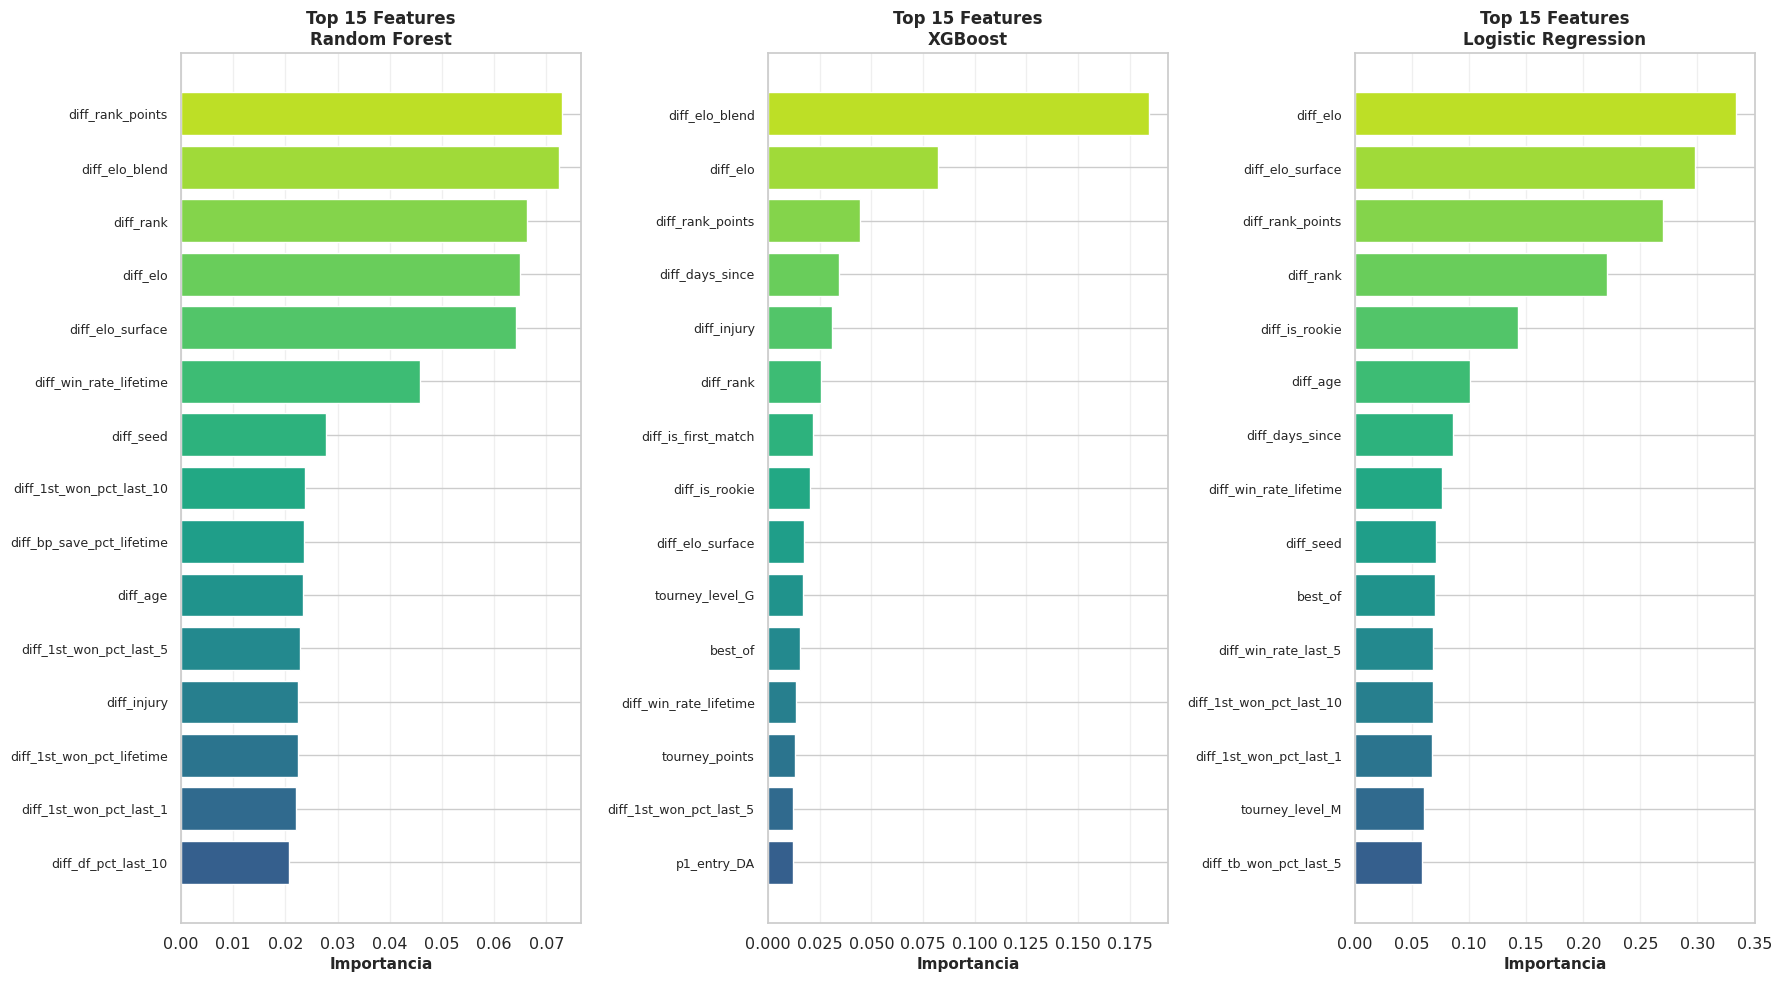

In [38]:
# Visualización de las top 15 features por modelo
fig, axes = plt.subplots(1, len(importance_df.columns), figsize=(18, 10))

if len(importance_df.columns) == 1:
    axes = [axes]

for idx, model in enumerate(importance_df.columns):
    top_15 = importance_df[model].nlargest(15).sort_values()
    
    axes[idx].barh(range(len(top_15)), top_15.values, color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top_15))))
    axes[idx].set_yticks(range(len(top_15)))
    axes[idx].set_yticklabels(top_15.index, fontsize=9)
    axes[idx].set_xlabel('Importancia', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Top 15 Features\n{model}', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show();

## 4.2 - Comparación: modelos lineales vs no lineales

Vamos a comparar qué features priorizan los modelos lineales frente a los no lineales.

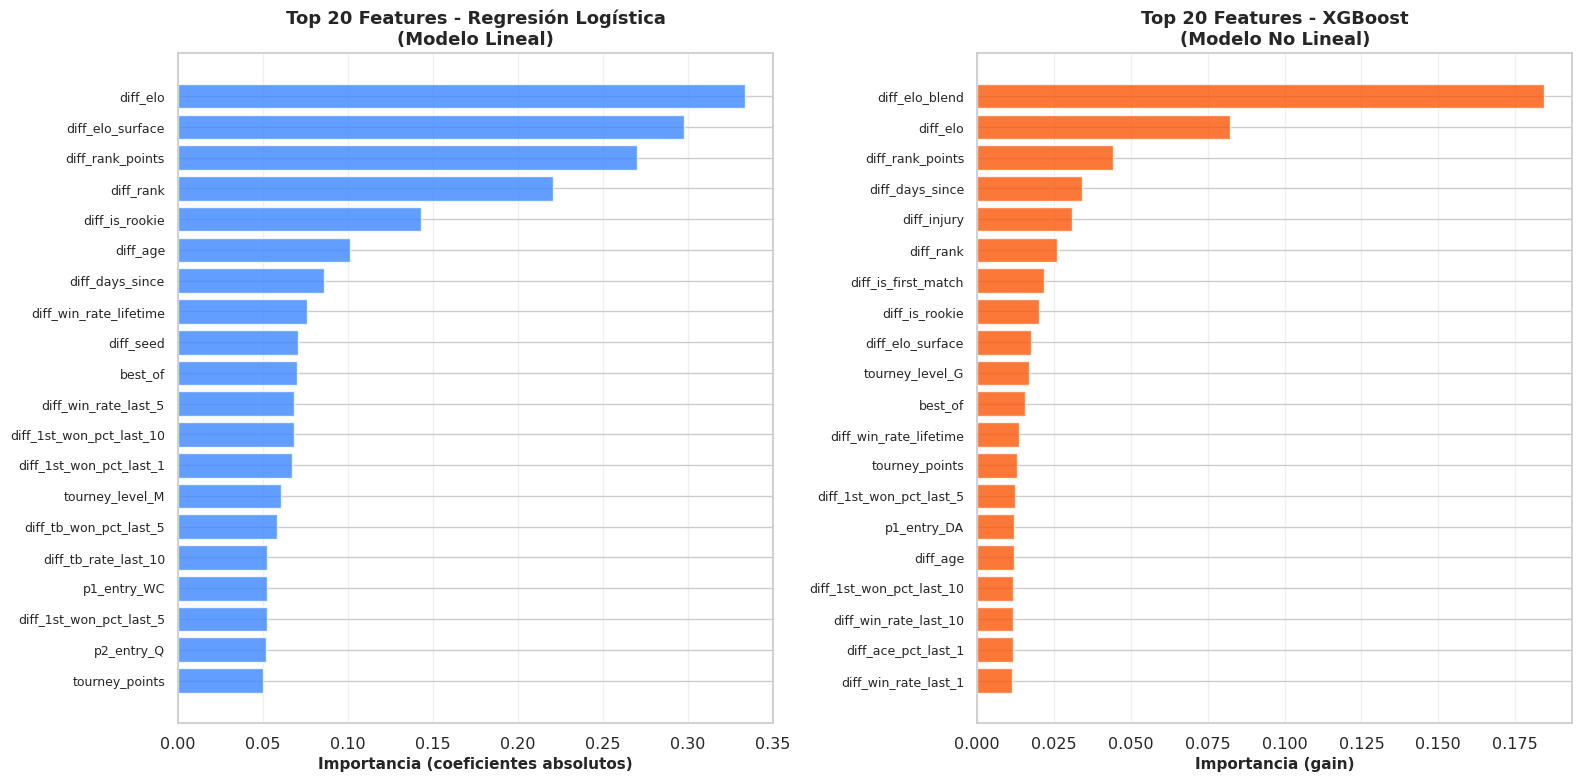


Análisis de features importantes (Top 10):

Features comunes en ambos modelos (6):
  - diff_rank_points
  - diff_days_since
  - diff_is_rookie
  - diff_elo
  - diff_rank
  - diff_elo_surface

Features solo importantes para Regresión Logística (4):
  - diff_win_rate_lifetime
  - diff_age
  - diff_seed
  - best_of

Features solo importantes para XGBoost (4):
  - diff_injury
  - diff_is_first_match
  - tourney_level_G
  - diff_elo_blend


In [39]:
# Comparación de features importantes entre modelos lineales y no lineales
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 20 features de Logistic Regression (lineal)
lr_top20 = importance_df['Logistic Regression'].nlargest(20)
axes[0].barh(range(len(lr_top20)), lr_top20.values, color='#3A86FF', alpha=0.8)
axes[0].set_yticks(range(len(lr_top20)))
axes[0].set_yticklabels(lr_top20.index, fontsize=9)
axes[0].set_xlabel('Importancia (coeficientes absolutos)', fontsize=11, fontweight='bold')
axes[0].set_title('Top 20 Features - Regresión Logística\n(Modelo Lineal)', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Top 20 features de XGBoost (no lineal)
xgb_top20 = importance_df['XGBoost'].nlargest(20)
axes[1].barh(range(len(xgb_top20)), xgb_top20.values, color='#FB5607', alpha=0.8)
axes[1].set_yticks(range(len(xgb_top20)))
axes[1].set_yticklabels(xgb_top20.index, fontsize=9)
axes[1].set_xlabel('Importancia (gain)', fontsize=11, fontweight='bold')
axes[1].set_title('Top 20 Features - XGBoost\n(Modelo No Lineal)', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de coincidencias
lr_top10 = set(importance_df['Logistic Regression'].nlargest(10).index)
xgb_top10 = set(importance_df['XGBoost'].nlargest(10).index)

comunes = lr_top10.intersection(xgb_top10)
solo_lr = lr_top10 - xgb_top10
solo_xgb = xgb_top10 - lr_top10

print("\nAnálisis de features importantes (Top 10):\n")
print(f"Features comunes en ambos modelos ({len(comunes)}):")
for feat in comunes:
    print(f"  - {feat}")

print(f"\nFeatures solo importantes para Regresión Logística ({len(solo_lr)}):")
for feat in solo_lr:
    print(f"  - {feat}")

print(f"\nFeatures solo importantes para XGBoost ({len(solo_xgb)}):")
for feat in solo_xgb:
    print(f"  - {feat}")

## 4.3 - Explicación con SHAP: Regresión Logística (modelo lineal)

SHAP (SHapley Additive exPlanations) nos ayuda a entender cómo cada feature contribuye a las predicciones individuales.

Generando gráficos SHAP para Regresión Logística...


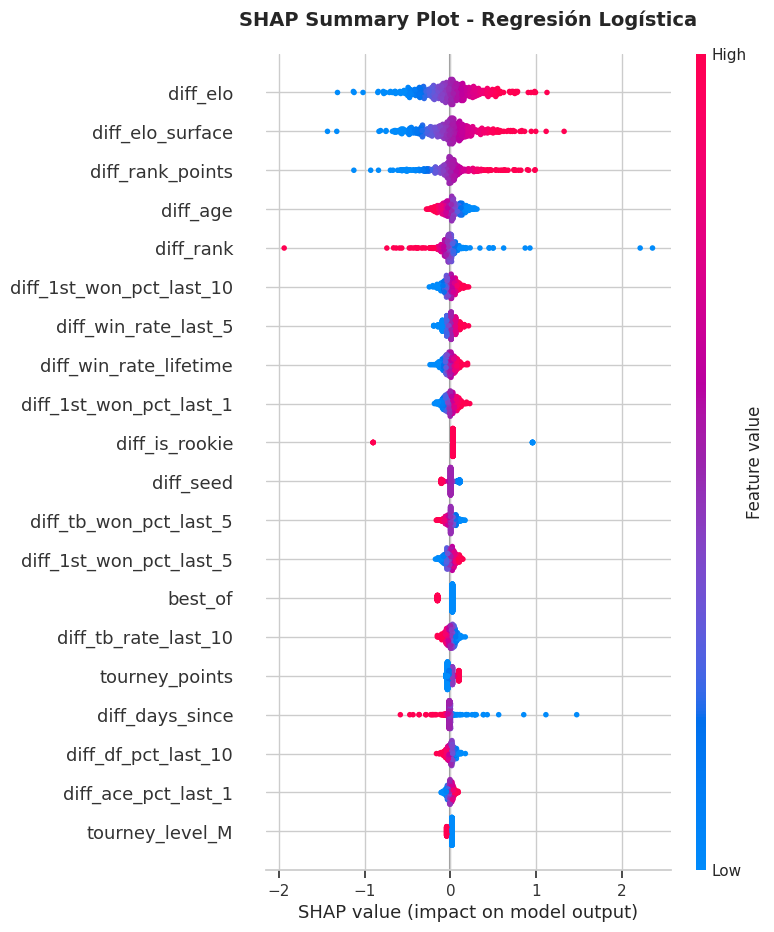

In [40]:
import shap

# Preparar datos para SHAP (usamos una muestra para que sea más rápido)
X_test_processed = preprocessor.transform(X_test)
X_test_sample = X_test_processed[:500]  # muestra de 500 ejemplos

# Modelo de regresión logística
lr_model = grid_log.best_estimator_.named_steps['clf']

# Crear explainer para regresión logística
explainer_lr = shap.LinearExplainer(lr_model, X_test_sample, feature_names=feature_names)
shap_values_lr = explainer_lr.shap_values(X_test_sample)

print("Generando gráficos SHAP para Regresión Logística...")

# Summary plot
plt.figure()
shap.summary_plot(shap_values_lr, X_test_sample, feature_names=feature_names, show=False, max_display=20)
plt.title('SHAP Summary Plot - Regresión Logística', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 4.4 - Explicación con SHAP: XGBoost (modelo no lineal)

Ahora hacemos lo mismo para XGBoost, que puede capturar relaciones no lineales más complejas.

Generando gráficos SHAP para XGBoost...


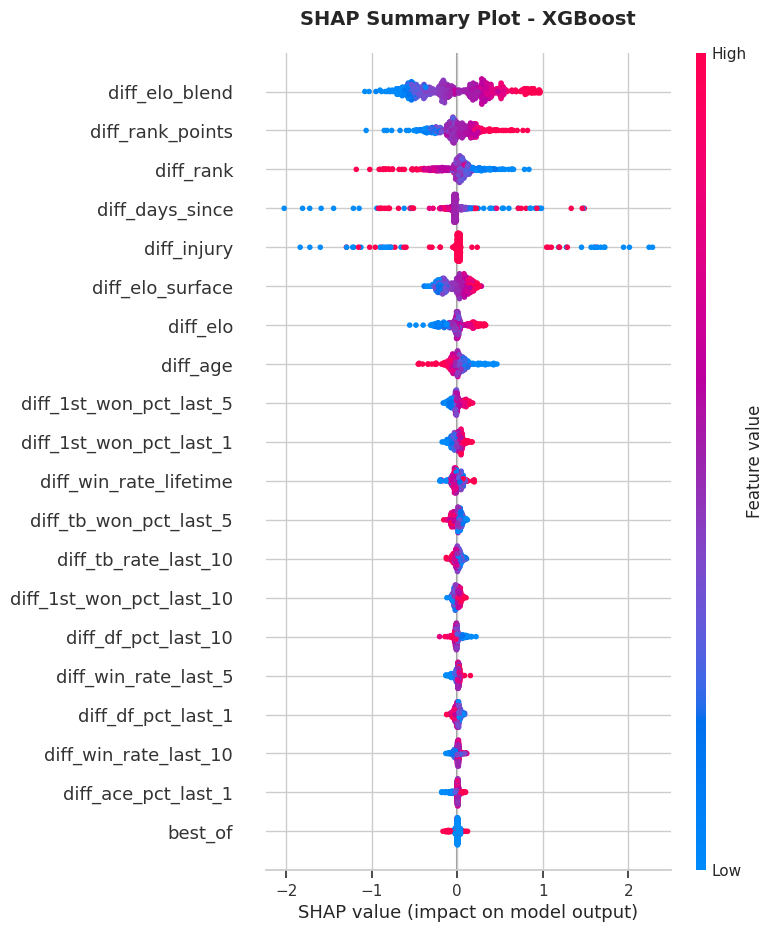

In [41]:
# Modelo XGBoost
xgb_model = grid_xgb.best_estimator_.named_steps['clf']

# Crear explainer para XGBoost (TreeExplainer es más eficiente para modelos basados en árboles)
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_sample)

print("Generando gráficos SHAP para XGBoost...")

# Summary plot
plt.figure()
shap.summary_plot(shap_values_xgb, X_test_sample, feature_names=feature_names, show=False, max_display=20)
plt.title('SHAP Summary Plot - XGBoost', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 4.5 - Análisis de ejemplos específicos

Vamos a analizar casos concretos para entender mejor cómo funcionan los modelos:
1. Ejemplos clasificados incorrectamente
2. Ejemplos con valores extremos
3. Casos donde no se usan los features más importantes
4. Ejemplos prototípicos (bien clasificados)

### 4.5.1 - Ejemplos mal clasificados

Primero miramos casos donde los modelos se equivocaron.

In [42]:
# Predicciones de ambos modelos en test
y_pred_lr = grid_log.best_estimator_.predict(X_test)
y_pred_xgb = grid_xgb.best_estimator_.predict(X_test)

# Encontrar ejemplos mal clasificados
errors_lr = np.where(y_pred_lr != y_test.values)[0]
errors_xgb = np.where(y_pred_xgb != y_test.values)[0]

# Errores comunes a ambos modelos
common_errors = np.intersect1d(errors_lr, errors_xgb)

print(f"Errores Regresión Logística: {len(errors_lr)} ({len(errors_lr)/len(y_test)*100:.1f}%)")
print(f"Errores XGBoost: {len(errors_xgb)} ({len(errors_xgb)/len(y_test)*100:.1f}%)")
print(f"Errores comunes: {len(common_errors)} ({len(common_errors)/len(y_test)*100:.1f}%)")

# Analizar 3 ejemplos mal clasificados con SHAP
print("ANÁLISIS DE EJEMPLOS MAL CLASIFICADOS:")

# Cogemos los primeros 3 errores comunes dentro de nuestra muestra
errors_in_sample = [idx for idx in common_errors if idx < 500][:3]

for i, idx in enumerate(errors_in_sample, 1):
    print(f"\nEjemplo {i} - Índice {idx}:")
    print(f"  Real: {y_test.iloc[idx]} | Predicho LR: {y_pred_lr[idx]} | Predicho XGB: {y_pred_xgb[idx]}")
    
    # SHAP values para este ejemplo
    print("\n  Top 5 features que influyeron en la predicción (XGBoost):")
    shap_vals = shap_values_xgb[idx]
    top_features_idx = np.argsort(np.abs(shap_vals))[-5:][::-1]
    
    for feat_idx in top_features_idx:
        feat_name = feature_names[feat_idx]
        feat_value = X_test_sample.iloc[idx, feat_idx]
        shap_value = shap_vals[feat_idx]
        print(f"    - {feat_name}: valor={feat_value:.3f}, SHAP={shap_value:.3f}")

Errores Regresión Logística: 3716 (34.0%)
Errores XGBoost: 3417 (31.3%)
Errores comunes: 3030 (27.7%)
ANÁLISIS DE EJEMPLOS MAL CLASIFICADOS:

Ejemplo 1 - Índice 0:
  Real: 0 | Predicho LR: 1 | Predicho XGB: 1

  Top 5 features que influyeron en la predicción (XGBoost):
    - diff_elo_blend: valor=0.430, SHAP=0.310
    - diff_elo_surface: valor=0.374, SHAP=0.079
    - diff_tb_won_pct_last_5: valor=-0.493, SHAP=0.063
    - diff_rank_points: valor=0.140, SHAP=0.056
    - diff_win_rate_lifetime: valor=0.153, SHAP=-0.047

Ejemplo 2 - Índice 3:
  Real: 0 | Predicho LR: 1 | Predicho XGB: 1

  Top 5 features que influyeron en la predicción (XGBoost):
    - diff_elo_blend: valor=2.116, SHAP=0.864
    - diff_elo: valor=1.761, SHAP=0.248
    - diff_rank_points: valor=1.078, SHAP=0.234
    - diff_elo_surface: valor=2.437, SHAP=0.197
    - diff_rank: valor=-0.282, SHAP=0.125

Ejemplo 3 - Índice 4:
  Real: 1 | Predicho LR: 0 | Predicho XGB: 0

  Top 5 features que influyeron en la predicción (XGBoos

### 4.5.2 - Ejemplos con valores extremos

Miramos partidos con características extremas (muy favorito vs muy underdog).

In [44]:
# Buscar features con "diff" o "rank" que suelen indicar diferencias entre jugadores
rank_features = [f for f in feature_names if 'rank' in f.lower() or 'diff' in f.lower()]

if len(rank_features) > 0:
    # Buscar el feature de diferencia de ranking más relevante
    main_rank_feature = rank_features[0]
    rank_col_idx = list(feature_names).index(main_rank_feature)
    
    # Ordenar por valores extremos de este feature
    rank_values = X_test_sample.iloc[:, rank_col_idx]
    extreme_indices = np.argsort(np.abs(rank_values))[-3:][::-1]
    
    print("ANÁLISIS DE EJEMPLOS CON VALORES EXTREMOS:")
    print(f"\nUsando feature: {main_rank_feature}\n")
    
    for i, idx in enumerate(extreme_indices, 1):
        print(f"Ejemplo {i} - Índice {idx}:")
        print(f"  Real: {y_test.iloc[idx]} | Predicho LR: {y_pred_lr[idx]} | Predicho XGB: {y_pred_xgb[idx]}")
        print(f"  {main_rank_feature}: {rank_values[idx]:.3f}")
        
        # Probabilidades de ambos modelos
        prob_lr = grid_log.best_estimator_.predict_proba(X_test.iloc[[idx]])[0]
        prob_xgb = grid_xgb.best_estimator_.predict_proba(X_test.iloc[[idx]])[0]
        
        print(f"  Probabilidades LR: P(0)={prob_lr[0]:.3f}, P(1)={prob_lr[1]:.3f}")
        print(f"  Probabilidades XGB: P(0)={prob_xgb[0]:.3f}, P(1)={prob_xgb[1]:.3f}")
else:
    print("No se encontraron features de ranking/diferencia para analizar valores extremos.")

ANÁLISIS DE EJEMPLOS CON VALORES EXTREMOS:

Usando feature: diff_elo_blend

Ejemplo 1 - Índice 457:
  Real: 0 | Predicho LR: 0 | Predicho XGB: 0
  diff_elo_blend: -4.284
  Probabilidades LR: P(0)=0.989, P(1)=0.011
  Probabilidades XGB: P(0)=0.953, P(1)=0.047
Ejemplo 2 - Índice 469:
  Real: 0 | Predicho LR: 0 | Predicho XGB: 0
  diff_elo_blend: -4.137
  Probabilidades LR: P(0)=0.982, P(1)=0.018
  Probabilidades XGB: P(0)=0.962, P(1)=0.038
Ejemplo 3 - Índice 400:
  Real: 1 | Predicho LR: 1 | Predicho XGB: 1
  diff_elo_blend: 3.940
  Probabilidades LR: P(0)=0.024, P(1)=0.976
  Probabilidades XGB: P(0)=0.050, P(1)=0.950


### 4.5.3 - Ejemplos prototípicos

Analizamos casos donde ambos modelos aciertan con alta confianza (ejemplos "fáciles").

In [45]:
# Encontrar ejemplos bien clasificados con alta confianza
correct_predictions = np.where(y_pred_xgb[:500] == y_test.values[:500])[0]

# Calcular confianza (probabilidad máxima) para XGBoost
probs_xgb = grid_xgb.best_estimator_.predict_proba(X_test[:500])
confidence_xgb = np.max(probs_xgb, axis=1)

# Ejemplos prototípicos: correctos y con alta confianza
prototypical_mask = (y_pred_xgb[:500] == y_test.values[:500]) & (confidence_xgb > 0.75)
prototypical_indices = np.where(prototypical_mask)[0][:3]

print("ANÁLISIS DE EJEMPLOS PROTOTÍPICOS (bien clasificados con alta confianza):")

for i, idx in enumerate(prototypical_indices, 1):
    print(f"\nEjemplo {i} - Índice {idx}:")
    print(f"  Real: {y_test.iloc[idx]} | Predicho: {y_pred_xgb[idx]}")
    print(f"  Confianza XGB: {confidence_xgb[idx]:.3f}")
    
    # Probabilidades
    prob_lr = grid_log.best_estimator_.predict_proba(X_test.iloc[[idx]])[0]
    prob_xgb = probs_xgb[idx]
    
    print(f"  Probabilidades LR: P(0)={prob_lr[0]:.3f}, P(1)={prob_lr[1]:.3f}")
    print(f"  Probabilidades XGB: P(0)={prob_xgb[0]:.3f}, P(1)={prob_xgb[1]:.3f}")
    
    # Top features para este ejemplo
    print("\n  Top 5 features más influyentes (XGBoost):")
    shap_vals = shap_values_xgb[idx]
    top_features_idx = np.argsort(np.abs(shap_vals))[-5:][::-1]
    
    for feat_idx in top_features_idx:
        feat_name = feature_names[feat_idx]
        feat_value = X_test_sample.iloc[idx, feat_idx]
        shap_value = shap_vals[feat_idx]
        print(f"    - {feat_name}: valor={feat_value:.3f}, SHAP={shap_value:.3f}")

ANÁLISIS DE EJEMPLOS PROTOTÍPICOS (bien clasificados con alta confianza):

Ejemplo 1 - Índice 5:
  Real: 0 | Predicho: 0
  Confianza XGB: 0.968
  Probabilidades LR: P(0)=0.335, P(1)=0.665
  Probabilidades XGB: P(0)=0.968, P(1)=0.032

  Top 5 features más influyentes (XGBoost):
    - diff_days_since: valor=-4.576, SHAP=-1.808
    - diff_injury: valor=3.738, SHAP=-1.296
    - diff_rank: valor=-0.372, SHAP=-0.137
    - diff_rank_points: valor=0.216, SHAP=-0.122
    - diff_tb_won_pct_last_5: valor=-1.039, SHAP=0.064

Ejemplo 2 - Índice 6:
  Real: 1 | Predicho: 1
  Confianza XGB: 0.782
  Probabilidades LR: P(0)=0.298, P(1)=0.702
  Probabilidades XGB: P(0)=0.218, P(1)=0.782

  Top 5 features más influyentes (XGBoost):
    - diff_elo_blend: valor=0.890, SHAP=0.529
    - diff_rank_points: valor=0.426, SHAP=0.199
    - diff_elo_surface: valor=1.001, SHAP=0.182
    - diff_elo: valor=0.761, SHAP=0.144
    - tourney_points: valor=1.850, SHAP=0.083

Ejemplo 3 - Índice 7:
  Real: 0 | Predicho: 0
  C

### 4.5.4 - Visualización detallada de un ejemplo

Vamos a visualizar en detalle cómo el modelo XGBoost toma la decisión para un ejemplo concreto.

Analizando ejemplo índice 0
Real: 0 | Predicho: 1


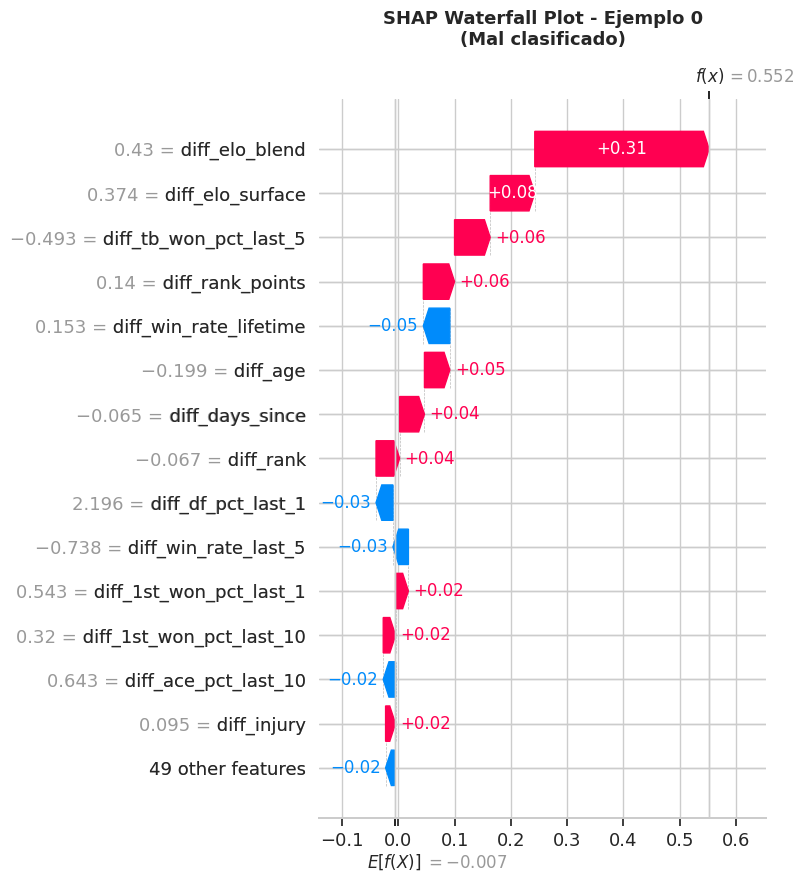


Force plot (muestra cómo cada feature empuja la predicción):


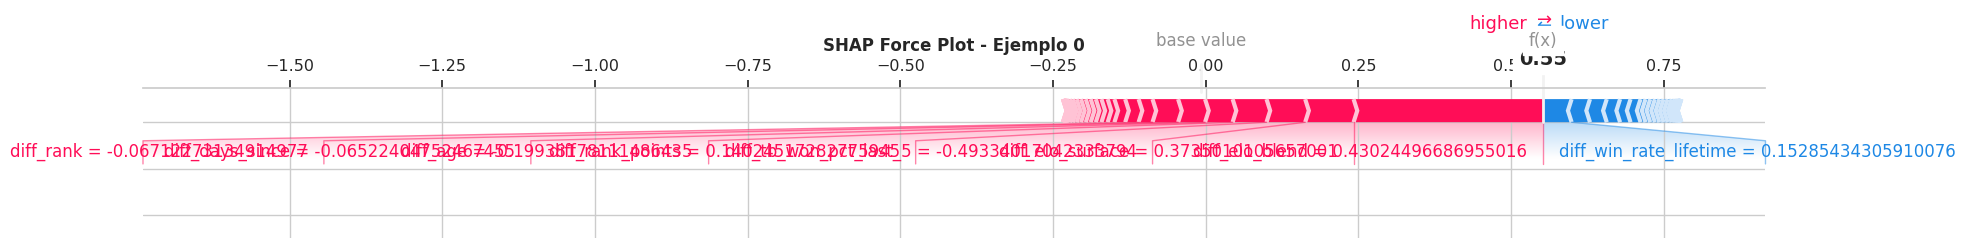

In [47]:
# Cogemos un ejemplo mal clasificado interesante
if len(errors_in_sample) > 0:
    example_idx = errors_in_sample[0]
    
    print(f"Analizando ejemplo índice {example_idx}")
    print(f"Real: {y_test.iloc[example_idx]} | Predicho: {y_pred_xgb[example_idx]}")
    
    # Waterfall plot para este ejemplo
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_xgb[example_idx],
            base_values=explainer_xgb.expected_value,
            data=X_test_sample.iloc[example_idx],
            feature_names=feature_names
        ),
        max_display=15,
        show=False
    )
    plt.title(f'SHAP Waterfall Plot - Ejemplo {example_idx}\n(Mal clasificado)', 
              fontsize=13, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()
    
    # Force plot para el mismo ejemplo
    shap.initjs()
    print("\nForce plot (muestra cómo cada feature empuja la predicción):")
    shap.force_plot(
        explainer_xgb.expected_value,
        shap_values_xgb[example_idx],
        X_test_sample.iloc[example_idx],
        feature_names=feature_names,
        matplotlib=True,
        show=False
    )
    plt.title(f'SHAP Force Plot - Ejemplo {example_idx}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No hay ejemplos mal clasificados en la muestra para visualizar.")

## 4.6 - Conclusiones sobre interpretabilidad

Después de analizar la importancia de features y los ejemplos específicos, podemos extraer varias conclusiones:

**Sobre las features importantes:**
- Tanto modelos lineales como no lineales coinciden en que las diferencias de ranking/nivel entre jugadores son cruciales
- XGBoost puede detectar relaciones más sutiles entre variables que la regresión logística no captura
- Las features de superficie y tipo de torneo también juegan un papel importante

**Diferencias entre modelos lineales y no lineales:**
- Regresión logística se basa mucho en features individuales con pesos fijos
- XGBoost combina múltiples features de forma más flexible y puede capturar interacciones
- Los modelos no lineales asignan importancia de forma más distribuida entre las features

**Sobre los ejemplos analizados:**
- Los casos mal clasificados suelen ser partidos donde las diferencias de nivel no son claras
- Los ejemplos con valores extremos (gran diferencia de ranking) se clasifican con más confianza
- Los ejemplos prototípicos muestran patrones claros que ambos modelos detectan fácilmente

**Implicaciones prácticas:**
- Para predicciones donde hay mucha incertidumbre, conviene revisar manualmente
- Los features de diferencia entre jugadores son los más fiables para predecir resultados
- SHAP nos ayuda a entender por qué el modelo falla en ciertos casos y validar que no usa información que no debería

# Parte 5 - Conclusiones

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Tiempo total de ejecución

In [48]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 5:00:00.551196
